# Analysis of Wikipedia Mathematicians

The goal of this kernel is to investigate the characteristics of famous mathematicians. This datset was scrapped from Wikipedia and cleaned in a prior kernel (see: https://github.com/JoePhilleo/Mathematicians-of-Wikipedia for details).

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dt
from sklearn import preprocessing
%matplotlib inline

# read data
df = pd.read_csv('data_cleaned.csv')

## Demographics

In [2]:
print('Number of People in Data:', df.shape[0])

Number of People in Data: 8596


In [3]:
# create dummy featues from 'sex or gender' feature
df['sex or gender'] = df['sex or gender'].fillna('')
df['male'] = df['sex or gender'].str.contains("'male'")
df['female'] = df['sex or gender'].str.contains("'female'")
df['not specified'] = ~(df['sex or gender'].str.contains("'male'")) & ~(df['sex or gender'].str.contains("'female'"))

print('Number of Mathematicians by Gender')
print('male: ', df['male'][df['male'] == True].count())
print('female: ', df['female'][df['female'] == True].count())
print('not specified: ', df['not specified'][df['not specified'] == True].count())
print()
print('Portion of Mathematicians by Gender')
print('male: ', str(int(df['male'][df['male'] == True].count()) / df.shape[0] * 100)[:6] +'%')
print('female: ', str(int(df['female'][df['female'] == True].count()) / df.shape[0] * 100)[:6] +'%')
print('not specified: ', str(int(df['not specified'][df['not specified'] == True].count()) / df.shape[0] * 100)[:6] +'%')

Number of Mathematicians by Gender
male:  7778
female:  790
not specified:  28

Portion of Mathematicians by Gender
male:  90.483%
female:  9.1903%
not specified:  0.3257%


Wow, that's a lot men. We'll further investigate these sex differences later in the kernel.

In [4]:
# see who was castrated
df[df['instance of'].str.contains('eunuch')]

print(df[df['instance of'].str.contains('eunuch')]['mathematicians'].tolist()[0], 'was castrated!')

Jia Xian was castrated!


## Birth, Death, and Lifespan

In [5]:
# Analyze demographics of mathematicians
df['year of birth'] = df['year of birth'].apply(pd.to_numeric, args=('coerce',))
df['year of death'] = df['year of death'].apply(pd.to_numeric, args=('coerce',))

In [6]:
def birthFeats(df):
    # filter values with approximate df or without birth year
    df = df[~(df['approx. date of birth'])]
    df = df[df['year of birth'].notnull()].reset_index(drop=True)
    
    df['decade born'] = (df['year of birth'] / 10).astype(int)*10
    return df

def lifeFeats(df):
    # create birth features
    df = birthFeats(df)
    
    # filter values without death year
    df = df[df['year of death'].notnull()]
    df = df[~(df['approx. date of death'])]

    df['mid year'] = (df['year of death'] + df['year of birth']) / 2
    df['lifespan'] = df['year of death'] - df['year of birth']
    df = df.sort_values(by='mid year').reset_index(drop=True)
    return df

dates_life = lifeFeats(df)
dates_birth = birthFeats(df)

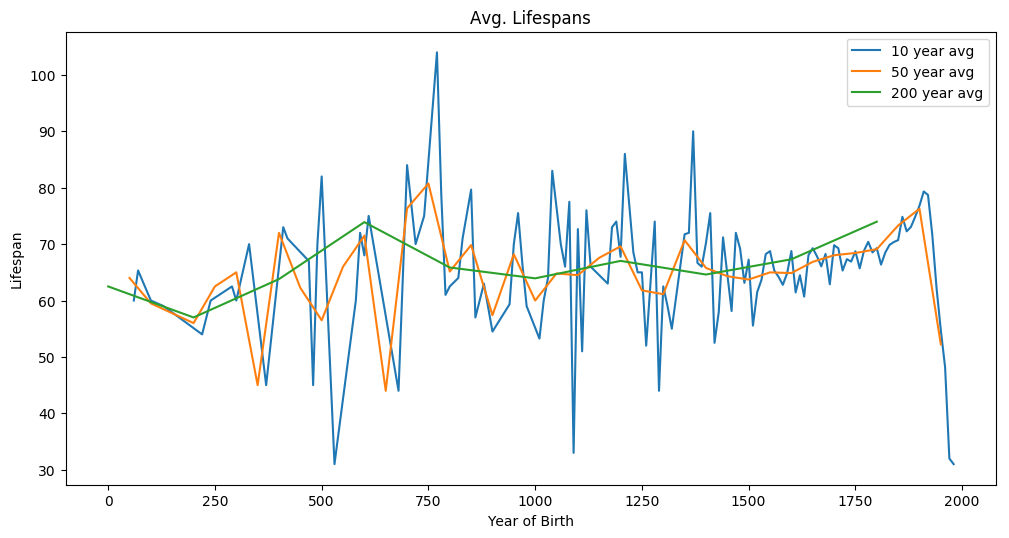

In [7]:
# sort data and separate it into early and late
dates = lifeFeats(df)
dates = dates[dates['year of birth'] > 0]
dates = dates.sort_values(by='mid year', ascending=False).reset_index(drop=True)

dates['half century born'] = (dates['year of birth'] / 50).astype(int)*50
dates['bicentential born'] = (dates['year of birth'] / 200).astype(int)*200

lifespan_10 = dates['lifespan'].groupby(dates['decade born']).mean()
lifespan_50 = dates['lifespan'].groupby(dates['half century born']).mean()
lifespan_200 = dates['lifespan'].groupby(dates['bicentential born']).mean()

plt.figure(figsize=(12, 6))
plt.plot(lifespan_10.index, lifespan_10)
plt.plot(lifespan_50.index, lifespan_50)
plt.plot(lifespan_200.index, lifespan_200)
plt.title('Avg. Lifespans')
plt.xlabel('Year of Birth')
plt.ylabel('Lifespan')
plt.legend(['10 year avg', '50 year avg', '200 year avg'])
plt.show()

From the chart, we see an increase of ~20 years in average mathematician lifespan from 1 A.D. to the present day, with high variance occuring from 250-1500 A.D. (likely due to small sample during that time period). We also see a somewhere severe 10-year lifespan reduction ~1300 A.D. which could be due to the Black Death.

See: https://en.wikipedia.org/wiki/Black_Death

Though it may look alarming, the dramatic fall in life span toward the present is not the concern it might appear. Since this graph is based only off of *dead* mathematicians (otherwise their lifespan could not be properly calculated), everyone in the data born after 1950 A.D. will bring down the mean lifespan since they will have necessarily died at a reltively young age. In other words, as year of birth approaches the current date, selection bias becomes an overwhelming factor in lifespan calculation, creating an alarming depiction even though many of the mathematicians born recently are still alive and will probably live longer than those before them.

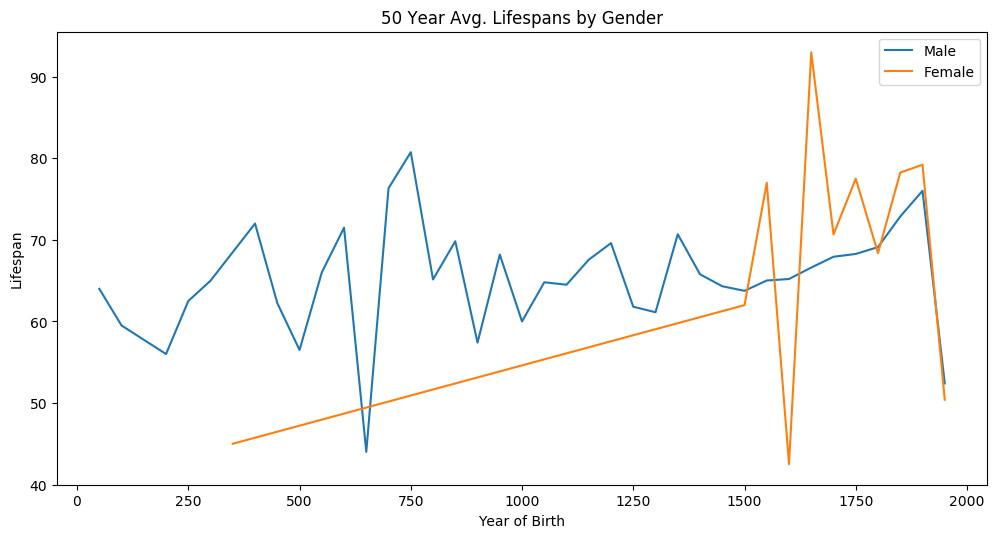

In [8]:
# sort data and separate it into early and late
dates = lifeFeats(df)
dates = dates[dates['year of birth'] > 0]
male = dates[dates['male']==1]
female = dates[dates['female']==1]

male = male.sort_values(by='mid year', ascending=False).reset_index(drop=True)
female = female.sort_values(by='mid year', ascending=False).reset_index(drop=True)

male['half century born'] = (male['year of birth'] / 50).astype(int)*50
female['half century born'] = (female['year of birth'] / 50).astype(int)*50
lifespan_50_male = male['lifespan'].groupby(male['half century born']).mean()
lifespan_50_female = female['lifespan'].groupby(female['half century born']).mean()

plt.figure(figsize=(12,6))
plt.plot(lifespan_50_male.index, lifespan_50_male)
plt.plot(lifespan_50_female.index, lifespan_50_female)
plt.title('50 Year Avg. Lifespans by Gender')
plt.xlabel('Year of Birth')
plt.ylabel('Lifespan')
plt.legend(['Male', 'Female'])
plt.show()

Because of the smaller sample size, the lifespan graph for females has a higher variance (e.g. is more erratic) than for males.

As we can see, most of our data is from the present and, broadly speaking, mathematician lifespans today are longer than in the past.

Still, those with an expansive knowledge of history might recognize that an average lifespan of +60 over the last 2000 years is really, really good. After all, LiveScience notes that the global lifespan for males in only 45.6 years 1907 was 66.4 years in 1957.

See: https://www.livescience.com/10569-human-lifespans-constant-2-000-years.html

Why then did mathematicians historically live so much longer than the average person? Some thoughts:


- **Selection Bias (Data)** -- becoming famous and accomplished enough to earn a Wikipedia page takes a long time. There may be many mathematicians throughout history who, because they died early, were forgotten and are thus not influencing this dataset.


- **Selection Bias (Profession)** -- similarly, becoming a mathematician (famous or not) is a long, difficult process. Those who make it necessarily also survived unsanitary childbirth, ravaging childhood disease, youthful accidents and mishaps, and possible war. Thus, by choosing mathematicians, we are innately looking at a sample of the population already possessing a higher than average life expectancy.


- **Explanation** -- mathematicians, by virtue of their work, were likely of a higher class and afforded better care than the average citizen of the time. Thus, mathematicians probably ate better, performed less excruciating physical labor, faced less exposure to the sun and harsh environment, and received better medical care. All of these factors could have helped them live longer.

## Profession
Many professions are similar or better understood when grouped into a broader occupation basket. Below, I went through the highest occuring occupations and manually grouped them. An automated solution did not appear readily achievable.

In [9]:
professor = ['professor', 'professeur', 'full professor', 'university teacher', 'teacher']

teacher = ['school_teacher', 'head teacher', 'school teacher', 'high school teacher']

inventor = ['inventor', 'entrepreneur', 'patent inventor']

religious = ['religious', 'deacon', 'Judaic scholar', 'priest',
             'Christian theology', 'vicar', 'cleric', 'missionary',
             'Digambara monk', 'parson',  'faqih','hellenist', 'minister',
             'occultist', 'rabbi', 'Bible translator', 'mystic', 'marja',
             'Anglican priest', 'theologian', 'bishop', 'cardinal', 'monk', 
             'Catholic Priest', 'nun', 'Christian apologetics', 'astrologer']

linguist = ['linguist',  'interlinguist',]

number_cruncher = ['number_cruncher', 'actuary', 'accountant', 'human computer']

political_scientist = ['political_scientist', 'political scientist', 'political writer',
                     'political philosopher', 'social scientist',
                     'archaeologist', 'demographer']

chemist = ['chemist', 'alchemist', 'metallurgist', 'mineralogist']

cryptographer = ['cryptographer', 'cryptoanalyst', 'criminologist', 'cryptologist']

physicist = ['physicist', 'theoretical physicist', 'biophysicist', 'astrophysicist',
             'telegraphy', 'quantum physicist', 'theoretical physics']

status = ['status', 'noble', 'coin collecting', 'art collector', 'philatelist',
        'numismatist', 'patron of the arts','philanthropist', 'sophist']

cool_random = ['cool_random', 'clockmaker', 'poker player', 'beekeeper', 'terrorist',
               'astronaut', 'ufologist', 'poker player']

athlete = ['athlete', 'basketball player', 'taekwondo athlete', 'squash player', 
           'athletics competitor', 'Australian rules footballer',
           'American football player', 'association football player',
           'sport cyclist','rugby union player','tennis player',
           'rower','association football manager', 'fencer', 'model', 
           'head coach', 'cricketer', 'lacrosse player', 'bodybuilding', 
           'bridge player', 'badminton player', 'association football referee']

economist = ['economist', 'game theory','economist', 'mathematical economics',
             'econometrician', 'economic historian']

philosopher =  ['philosopher', 'epistemologist', 'metaphysician','French moralists',
                'political philosopher', 'philosopher of science', 'ethicist', 
                'analytic philosopher', 'natural philosophy', 'philosopher of language',
                'social philosopher']

biologist = ['biologist', 'neuroscientist','botanist', 'neurologist', 'genealogist',
             'entomologist', 'physiologist','beekeeper','zoologist',
             'theoretical biologist','cognitive scientist','geneticist',
             'computational biologist']

musician = ['musician', 'singer', 'disc jockey', 'music educator', 'saxophonist',
            'jazz musician','music theorist', 'musician',  'music historian',
            'musicologist', 'violinist','composer', 'songwriter', 'pianist',
            'cellist', 'singer-songwriter']

lawyer = ['lawyer', 'poet lawyer', 'jurist', 'judge']

businessperson = ['businessperson', 'entrepreneur', 'consultant', 'banker']

writer = ['writer', 'childrens writer', 'printmaker',' playwright','author',
          'journalist', 'literary', 'poet lawyer', 'autobiographer',
          'poet', 'literary critic', 'printer', 'science writer',
          'scribe', 'opinion journalist', 'blogger', 'non-fiction writer',
          'science fiction writer', 'newspaper editor', 'librettist',
          'essayist', 'publisher', 'writer', 'grammarian', 'editor',
          'novelist','biographer', 'epigrammatist']


politician =  ['politician', 'trade unionist', 'statesman', 'officer', 'civil servant',
               'orator', 'chairperson', 'pacifist', 'public speaker', 'vice president',
               'political prisoner', 'dissident', 'resistance fighter',
               'anti-war activist', 'revolutionary', 'activist', 'politician'
               'political activist','peace activist', 'anti-vaccine activist',
               'human rights activist', 'diplomat']


health = ['health', 'diarist','radiologist', 'physician', 'pharmacist', 'paramedic', 'surgeon']

geologist = ['geologist', 'speleologist', 'calligrapher', 'geomatics engineering',
             'historian of cartography', 'geologist', 'geographer', 'agronomist'
             'oceanographer', 'selenographer', 'geophysicist', 'seismologist']

computer_science = ['computer_science', 'computer science', 'game designer',  'software engineer', 'roboticist',
                    'artificial intelligence researcher', 'computer scientist',
                    'computational biologist', 'programmer']

artist = ['artist', 'street artist', 'painter', 'art historian', 'photographer',
         'sculptor']

engineer = [ 'engineer', 'civil engineer', 'aerospace engineer', 'mechanical engineer', 
            'engineer of roads and bridges', 'mining engineer', 'geomatics engineering',]


media = ['media', 'media critic', 'television presenter', 'television actor',
         'screenwriter', 'stage actor', 'circus performer', 'actor', 'film actor',
         'radio personality', 'film director', 'juggler', 'stage magician']

military = ['military', 'military historian', 'navy officer', 'military personnel']

chess = ['chess', 'chess player', 'chess official', 'chess composer']


historian = ['historian', 'literary historian','historian of science',
             'historian of mathematics', 'philosophy historian']

mathematician = ['mathematician', 'statistician', 'topologist']

astronomer = ['astronomer', 'astronaut', 'aerospace engineer',
              'astrophysicist', 'cosmographer','cosmologist']

In [10]:
# Create dummy variables for each occupation bin created above

professions = [professor, teacher, inventor, religious, linguist,
               number_cruncher, political_scientist, chemist, cryptographer,
               physicist, status, cool_random, athlete, economist, astronomer,
               philosopher, biologist, musician, lawyer, businessperson, writer,
               politician, health, geologist, computer_science, artist,
               engineer, media, military, chess, historian, mathematician]

columns = [i[0] for i in professions]

for i in range(len(professions)):
    df[columns[i]] = [0 for k in df.mathematicians]
    for j in professions[i]:
        df.loc[df[columns[i]] == 0, columns[i]] = df['occupation'].loc[df[columns[i]] == 0].str.contains(j)

In [11]:
# Count occurence of professions for all data (will use later)

columns = []
counts = []
for i in professions:
    columns.append(i[0])
    counts.append(df['mathematicians'][df[i[0]]].count())

occupations = pd.concat([pd.DataFrame(columns), pd.DataFrame(counts)], axis=1)
occupations.columns = ['occupation', 'count']
occupations = occupations.sort_values(by='count', ascending=False).reset_index(drop=True)

occupations[:5]

,occupation,count
0,mathematician,7811
1,professor,2567
2,physicist,560
3,astronomer,546
4,computer_science,491


It looks like the overwhelming number of Wikipedia mathematicians are "mathematicians" by profession, which makes sense. To better understand our data, let's split our data into two groups:
1. mathematicians by profession
2. mathematicians in some other capacity

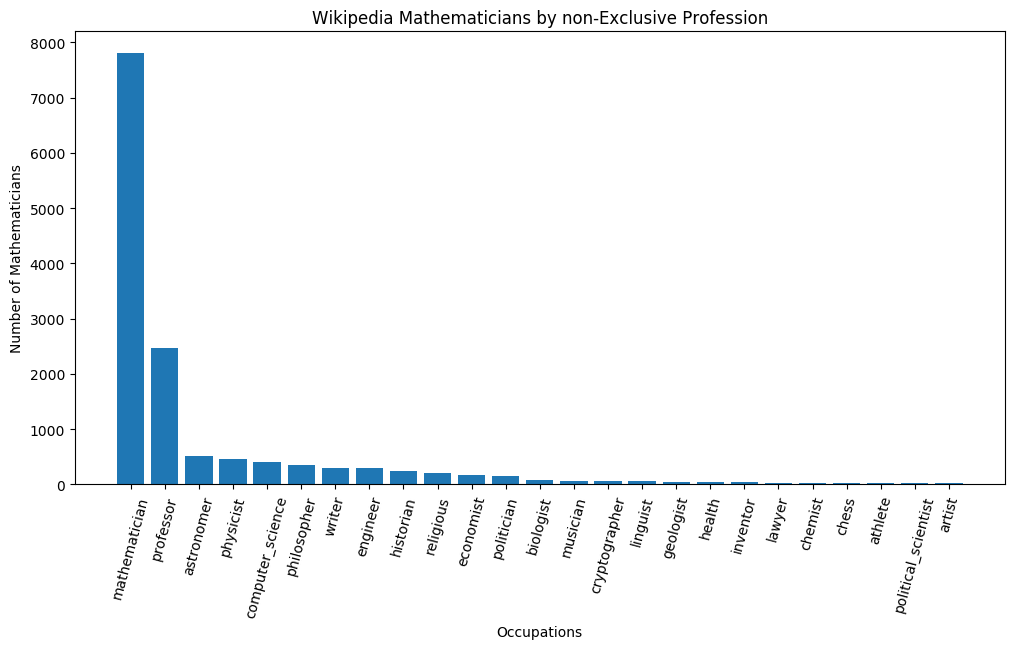

In [12]:
# Count and plot occurence of mathematicians by profession
df_math = df[df['mathematician'] == 1]

# count
columns = []
counts = []
for i in professions:
    columns.append(i[0])
    counts.append(df_math['mathematicians'][df_math[i[0]]].count())

occupations_math = pd.concat([pd.DataFrame(columns), pd.DataFrame(counts)], axis=1)
occupations_math.columns = ['occupation', 'count']
occupations_math = occupations_math.sort_values(by='count', ascending=False).reset_index(drop=True)

# plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(np.arange(len(occupations_math[:25])), occupations_math['count'][:25], align='center', ecolor='black')
plt.xticks(range(len(occupations_math[:25])), occupations_math['occupation'][:25], rotation=75)
ax.set_xticklabels(occupations_math['occupation'][:25])
ax.set_xlabel('Occupations')
ax.set_ylabel('Number of Mathematicians')
ax.set_title('Wikipedia Mathematicians by non-Exclusive Profession')
plt.show()

Many Wikipedia-worthy mathematicians *by profession* are also professors, astronomers, physicists, computer scientists, philosophers, writers, etc. However, the vast majority of Wikipedia-worthy professional mathematicians are solely mathematicians, i.e. they do not teach or also do work in another field.

Let's take a look at the occupations of Wikipedia-worthy mathematicians who are **not** mathematicians by profession.

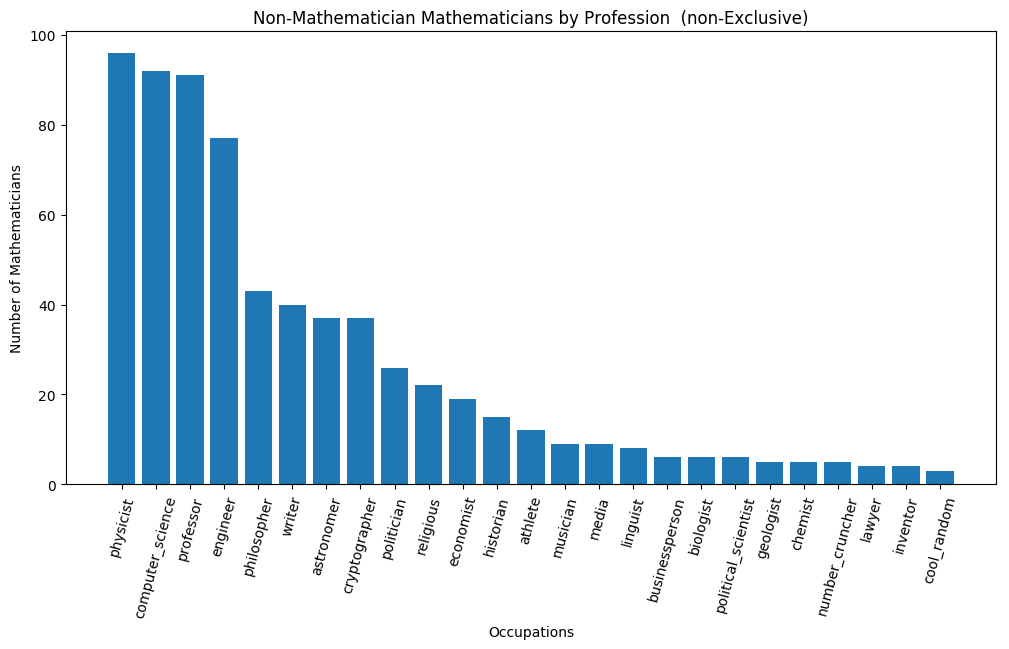

In [13]:
# Count and plot occurence of professions for mathematicians
df_non_math = df[df['mathematician'] != 1]

# count
columns = []
counts = []
for i in professions:
    columns.append(i[0])
    counts.append(df_non_math['mathematicians'][df_non_math[i[0]]].count())

occupations_non_math = pd.concat([pd.DataFrame(columns), pd.DataFrame(counts)], axis=1)
occupations_non_math.columns = ['occupation', 'count']
occupations_non_math = occupations_non_math.sort_values(by='count', ascending=False).reset_index(drop=True)

# Plot the occupations distribution for non-mathematician mathematicians
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(np.arange(len(occupations_non_math[:25])), occupations_non_math['count'][:25], align='center', ecolor='black')
plt.xticks(range(len(occupations_non_math[:25])), occupations_non_math['occupation'][:25], rotation=75)
ax.set_xticklabels(occupations_non_math['occupation'][:25])
ax.set_xlabel('Occupations')
ax.set_ylabel('Number of Mathematicians')
ax.set_title('Non-Mathematician Mathematicians by Profession  (non-Exclusive)')
plt.show()

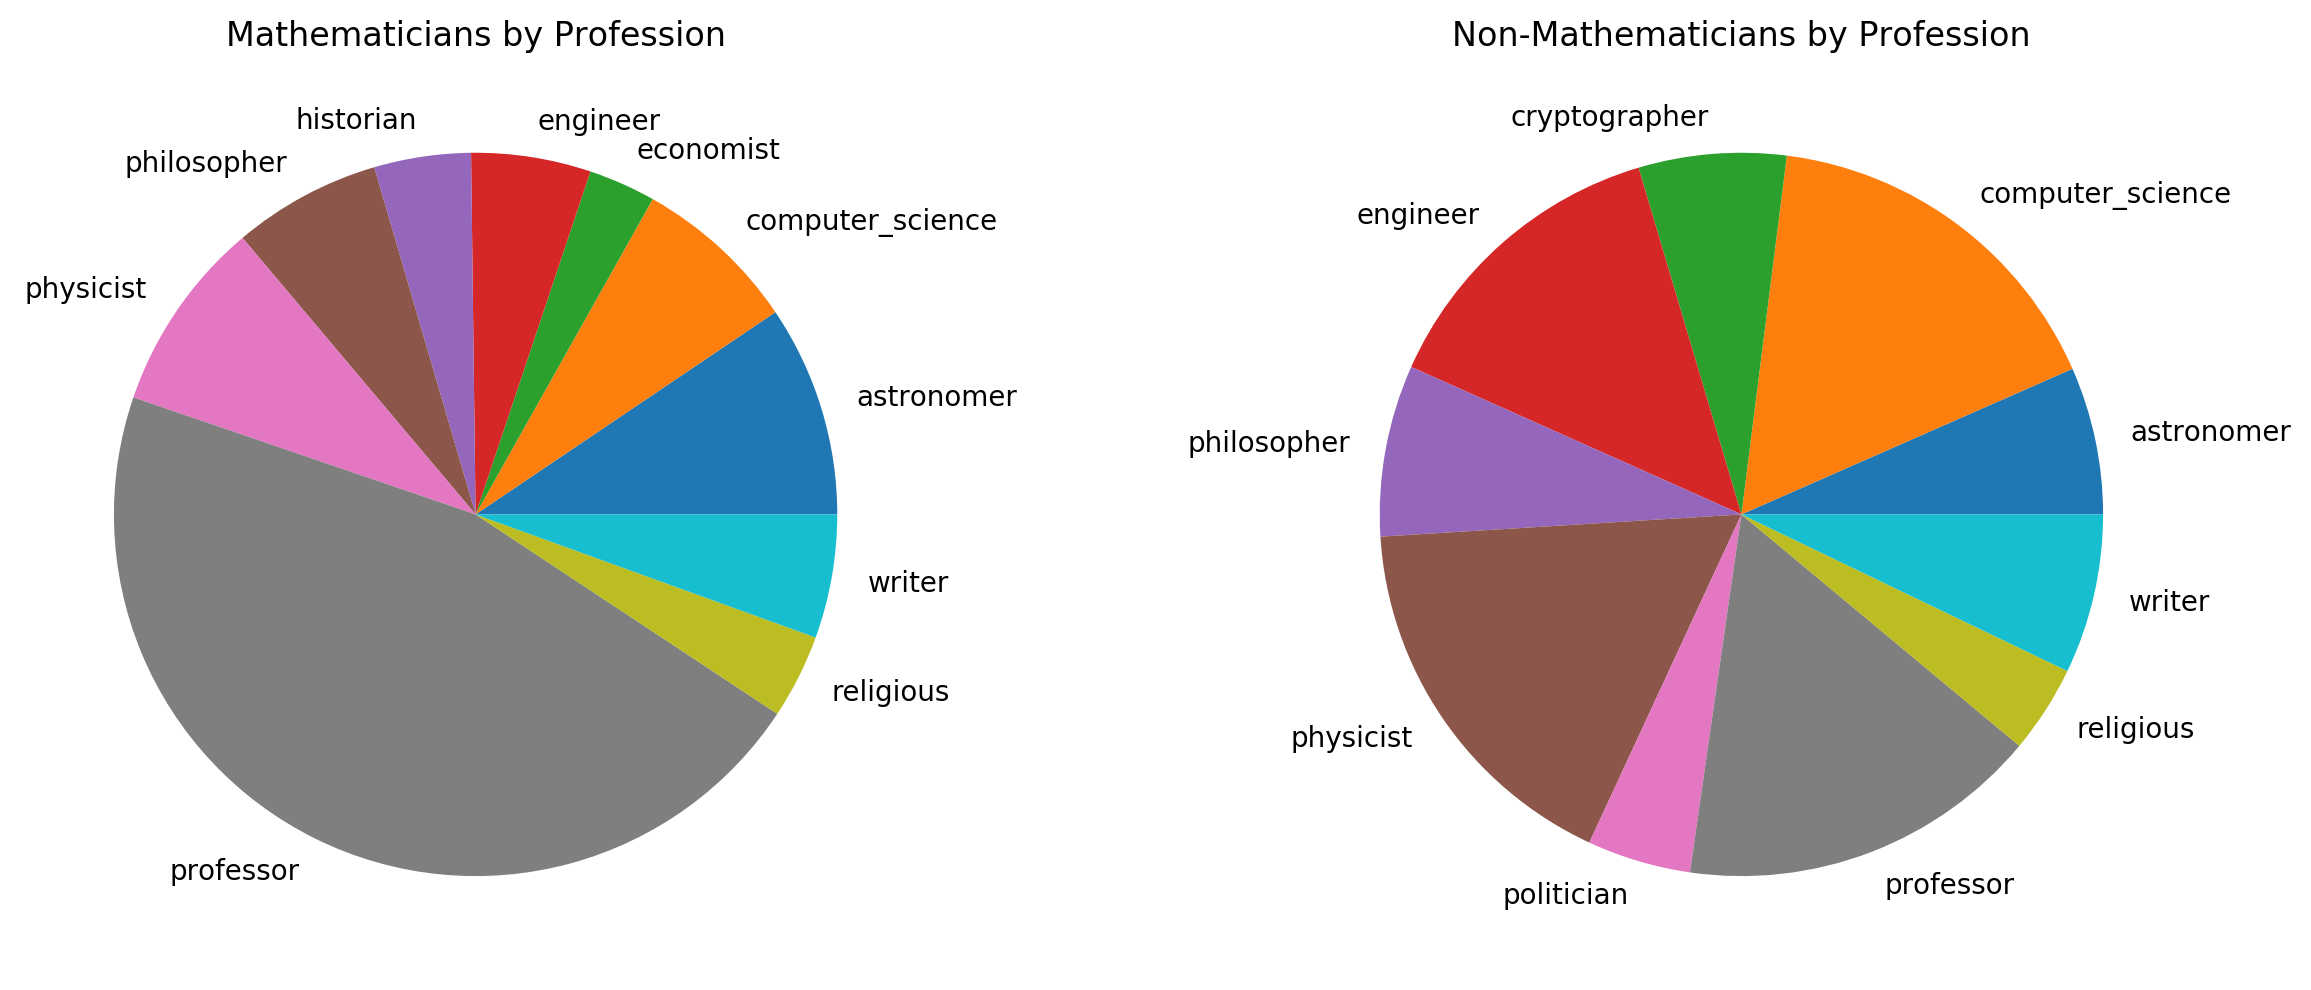

In [14]:
# plot comparison between mathematicians and non-mathematicians
n = 12
j = 10
fig, (ax1, ax2) = plt.subplots(ncols=2, subplot_kw={'aspect':'equal'}, dpi=200)
fig.subplots_adjust(wspace=.4)
fig.set_size_inches(14, 14)

occ1 = occupations_math[1:j+1].sort_values('occupation').reset_index(drop=True)
occ2 = occupations_non_math[0:j].sort_values('occupation').reset_index(drop=True)

ax1.pie(occ1['count'], labels = occ1['occupation'].tolist())
ax1.set_title('Mathematicians by Profession', {'fontsize': n})
ax2.pie(occ2['count'], labels = occ2['occupation'].tolist())
ax2.set_title('Non-Mathematicians by Profession', {'fontsize': n})
plt.show()

"Non-mathematician" mathematicians tend to work in highly quantitative fields (e.g. physics, computer science, astronomy, cryptography, economics) and complex, abstract domains (e.g. philosophy, religion), but generally avoid teaching.

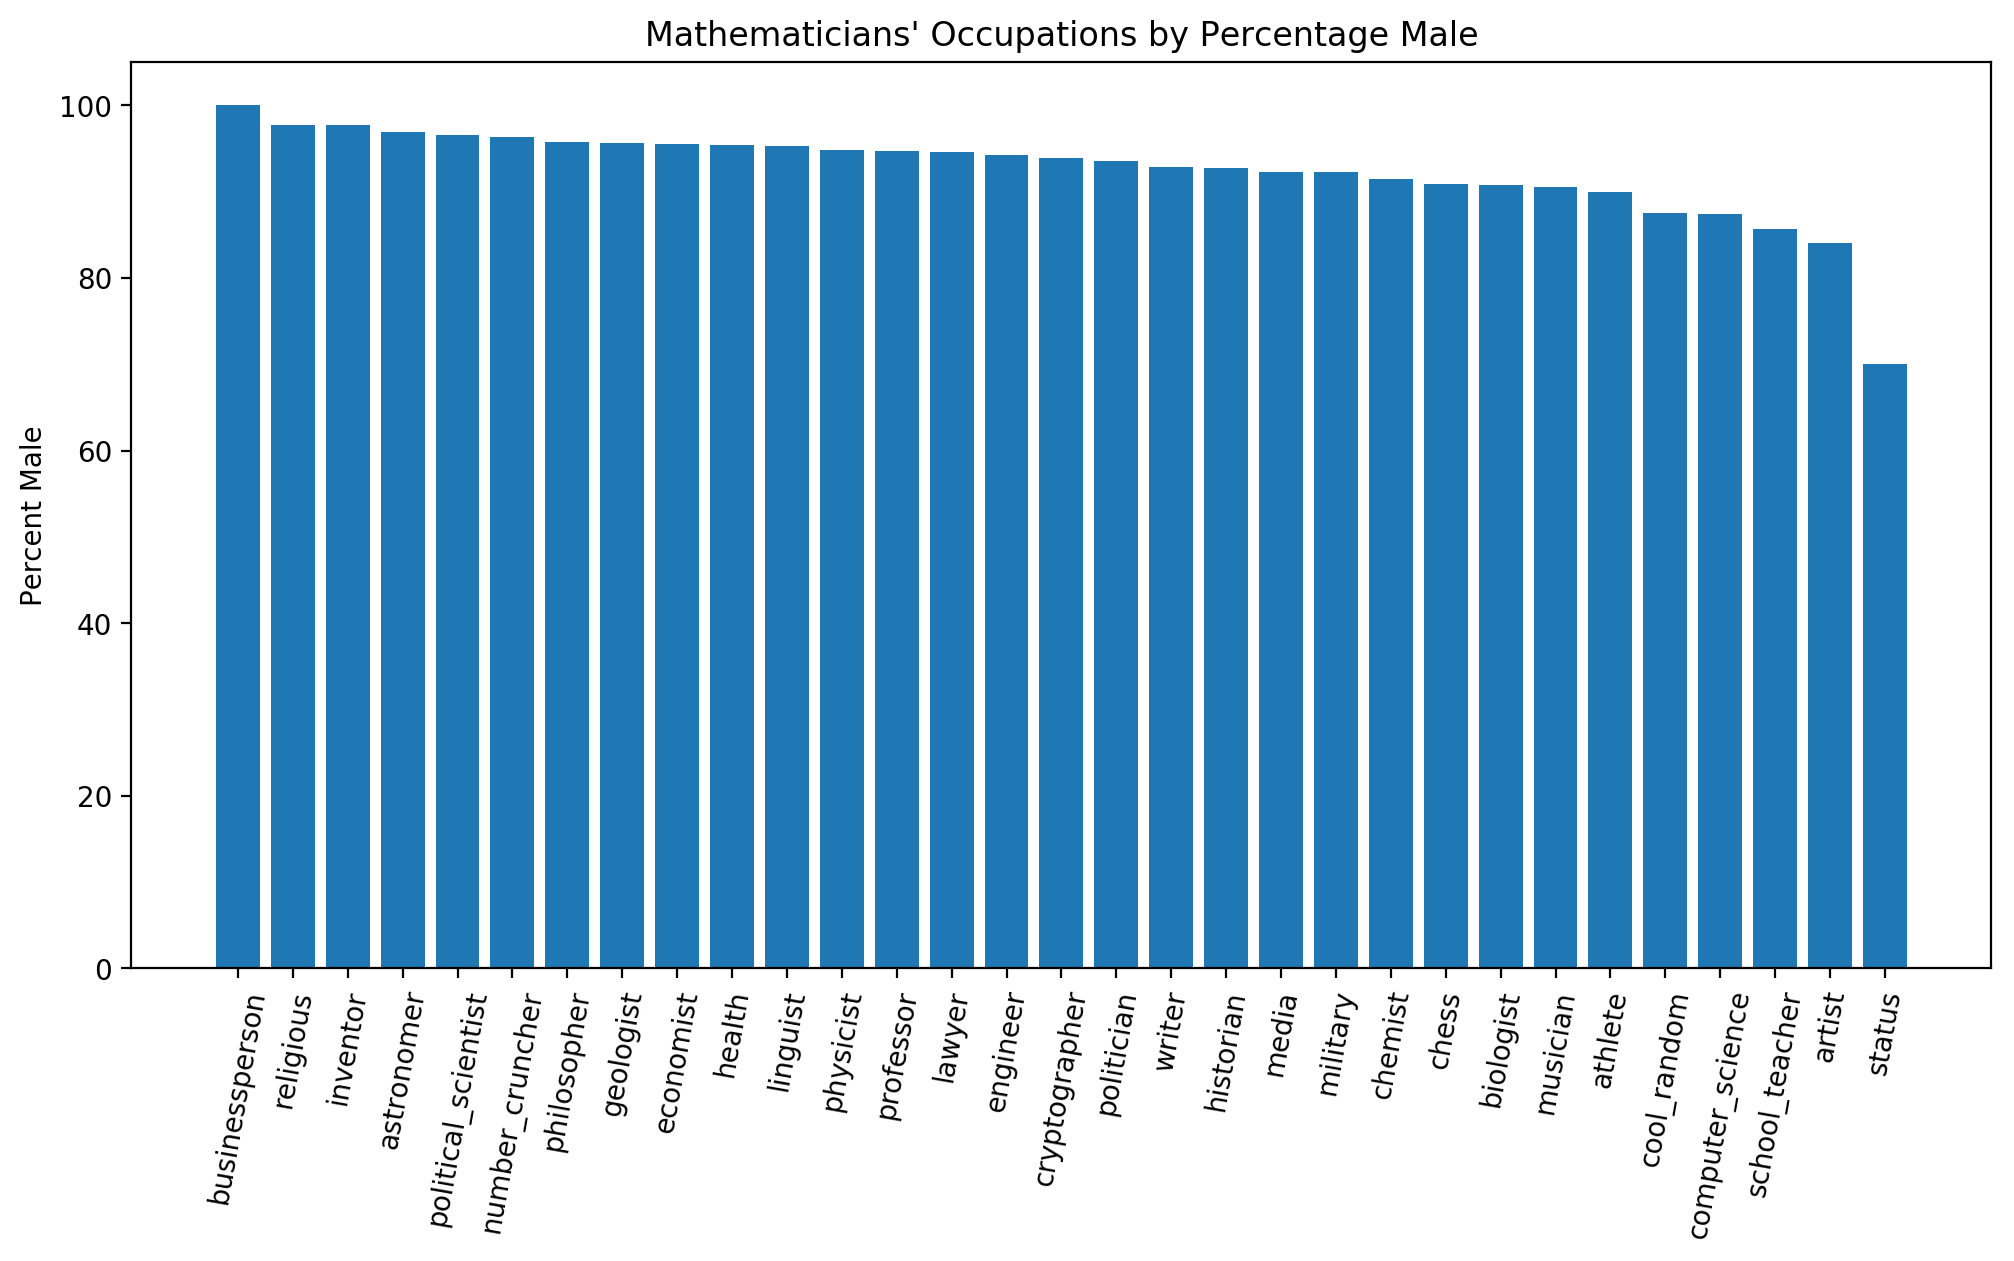

In [15]:
# plot professions by gender
columns = []
counts = []
df_male = df[df['male']==1]
for i in professions:
    columns.append(i[0])
    counts.append(df_male['mathematicians'][df_male[i[0]]].count())

occupations_male = pd.concat([pd.DataFrame(columns), pd.DataFrame(counts)], axis=1)
occupations_male.columns = ['occupation', 'count male']
occupations_male = occupations_male.sort_values(by='count male', ascending=False).reset_index(drop=True)

occupations_data = pd.concat([occupations, occupations_male['count male']], axis=1)
occupations_data['percent male'] = 100 * occupations_data['count male'] / occupations_data['count']

size = 50
occupations_data = occupations_data[1:size+1].sort_values(by='percent male', ascending=False)

plt.figure(figsize=(12, 6), dpi=200)
plt.bar(range(len(occupations_data)), occupations_data['percent male'], align='center')
plt.xticks(range(len(occupations_data)), occupations_data['occupation'], rotation=80)
plt.ylabel('Percent Male')
plt.title("Mathematicians' Occupations by Percentage Male")
plt.show()

Looks like none of the sub-professions are heavily female (or less heavily male).

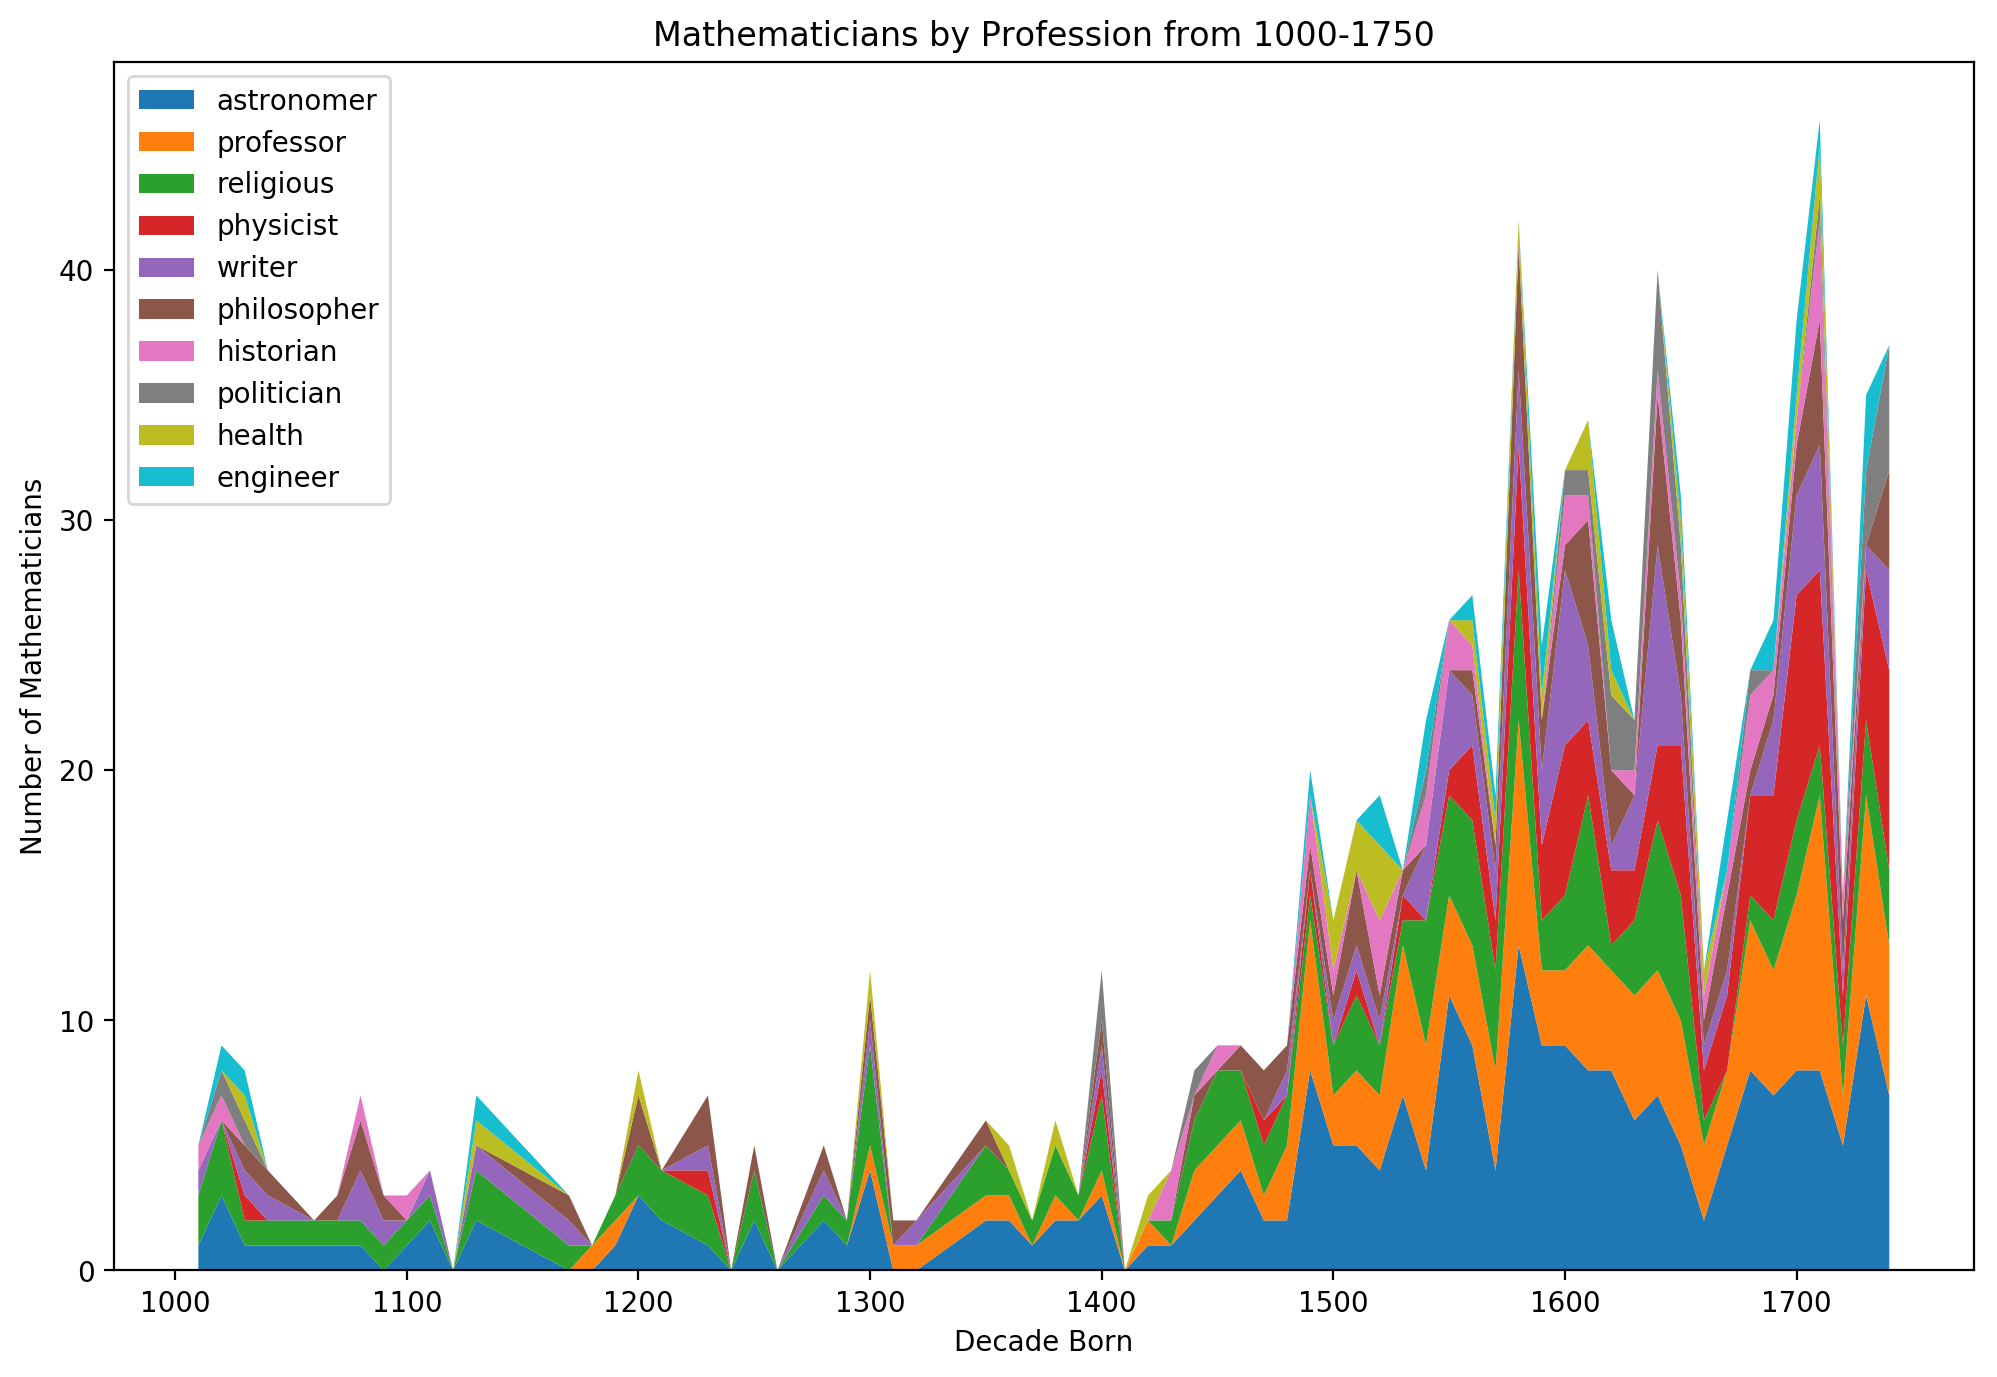

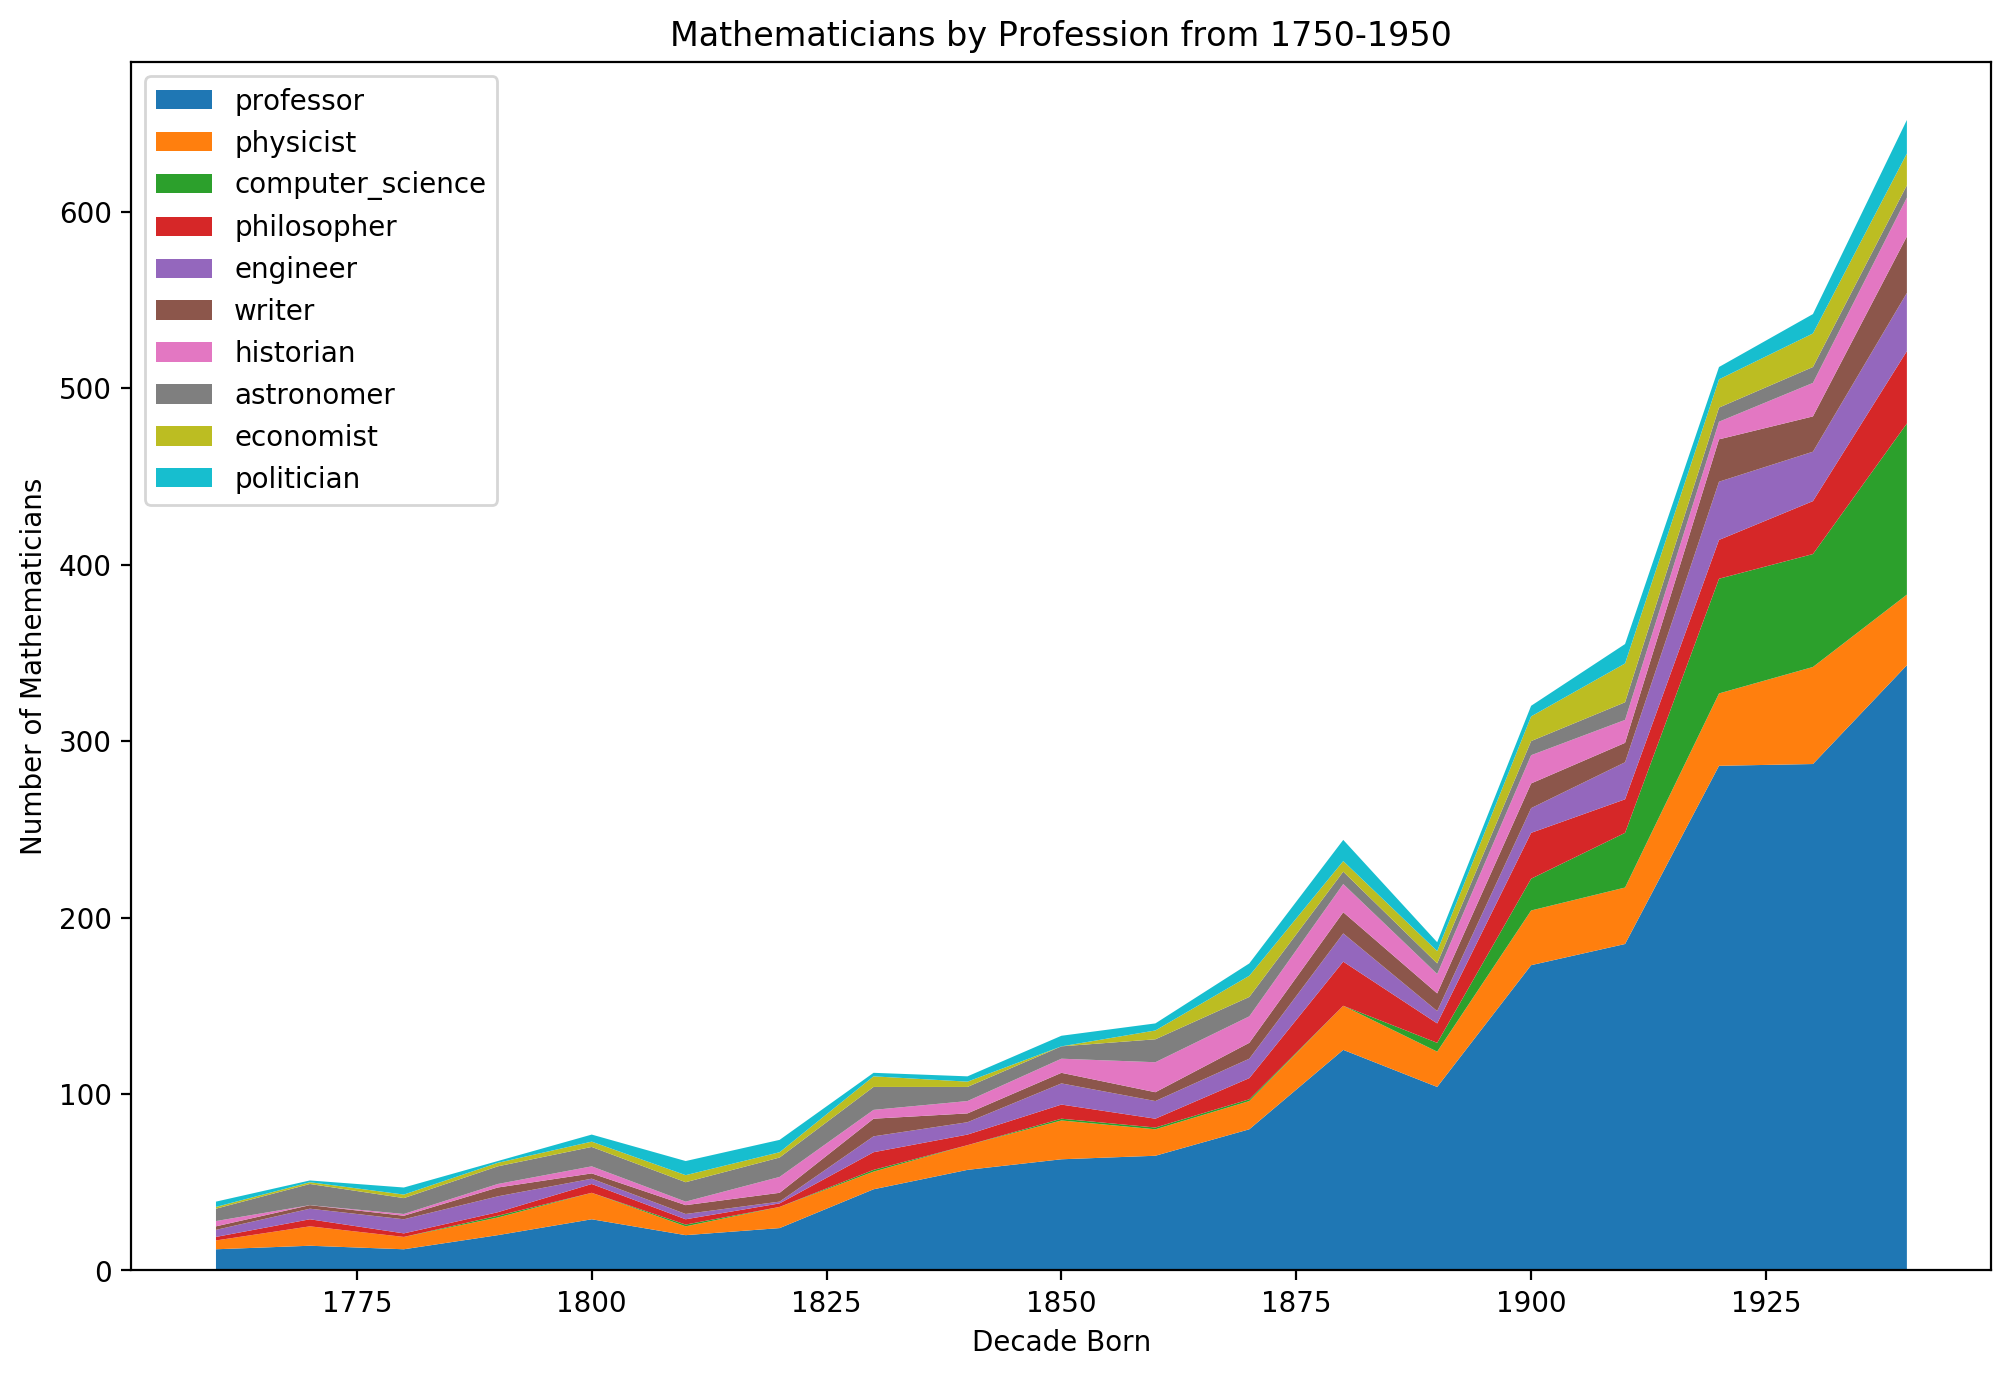

In [16]:
# plot popularity of professions over time

# 1000-1750
dates = birthFeats(df)
dates = dates[(dates['decade born'] > 1000) & (dates['decade born'] < 1750)]
dates = dates.groupby(['decade born']).sum()
dates = dates[[i for i in occupations['occupation'][1:]]]
columns = dates.sum().sort_values(ascending=False)[:10]
dates = dates[columns.index]
decades = dates.index

fig, ax = plt.subplots(figsize=(12, 8), dpi=200)
ax.stackplot(decades, dates.T, labels=columns.index)
ax.set_xlabel('Decade Born')
ax.set_ylabel('Number of Mathematicians')
ax.set_title('Mathematicians by Profession from 1000-1750')
plt.legend(loc = 'upper left')
plt.show()


# 1750-1950
dates = birthFeats(df)
dates = dates[(dates['decade born'] > 1750) & (dates['decade born'] < 1950)]
dates = dates.groupby(['decade born']).sum()
dates = dates[[i for i in occupations['occupation'][1:]]]
columns = dates.sum().sort_values(ascending=False)[:10]
dates = dates[columns.index]
decades = dates.index

fig, ax = plt.subplots(figsize=(12, 8), dpi=200)
ax.stackplot(decades, dates.T, labels=columns.index)
ax.set_xlabel('Decade Born')
ax.set_ylabel('Number of Mathematicians')
ax.set_title('Mathematicians by Profession from 1750-1950')
plt.legend(loc = 'upper left')
plt.show()

Though Astronomers, physicists, writers, and philosophers comprised many of the early notable mathematicians, today almost all famous mathematicians are researchers, professors, or highly technical computer scientists or physicists.

The reduction of religious-figure-mathematicians in the late 1600s is interesting, and may have resulted from the Peace of Westphalia in 1648 which relegated religion to a national (i.e. political) decision and is widely seen to have reduced the power of the Church. The establishment of universities may have played a significant role too.

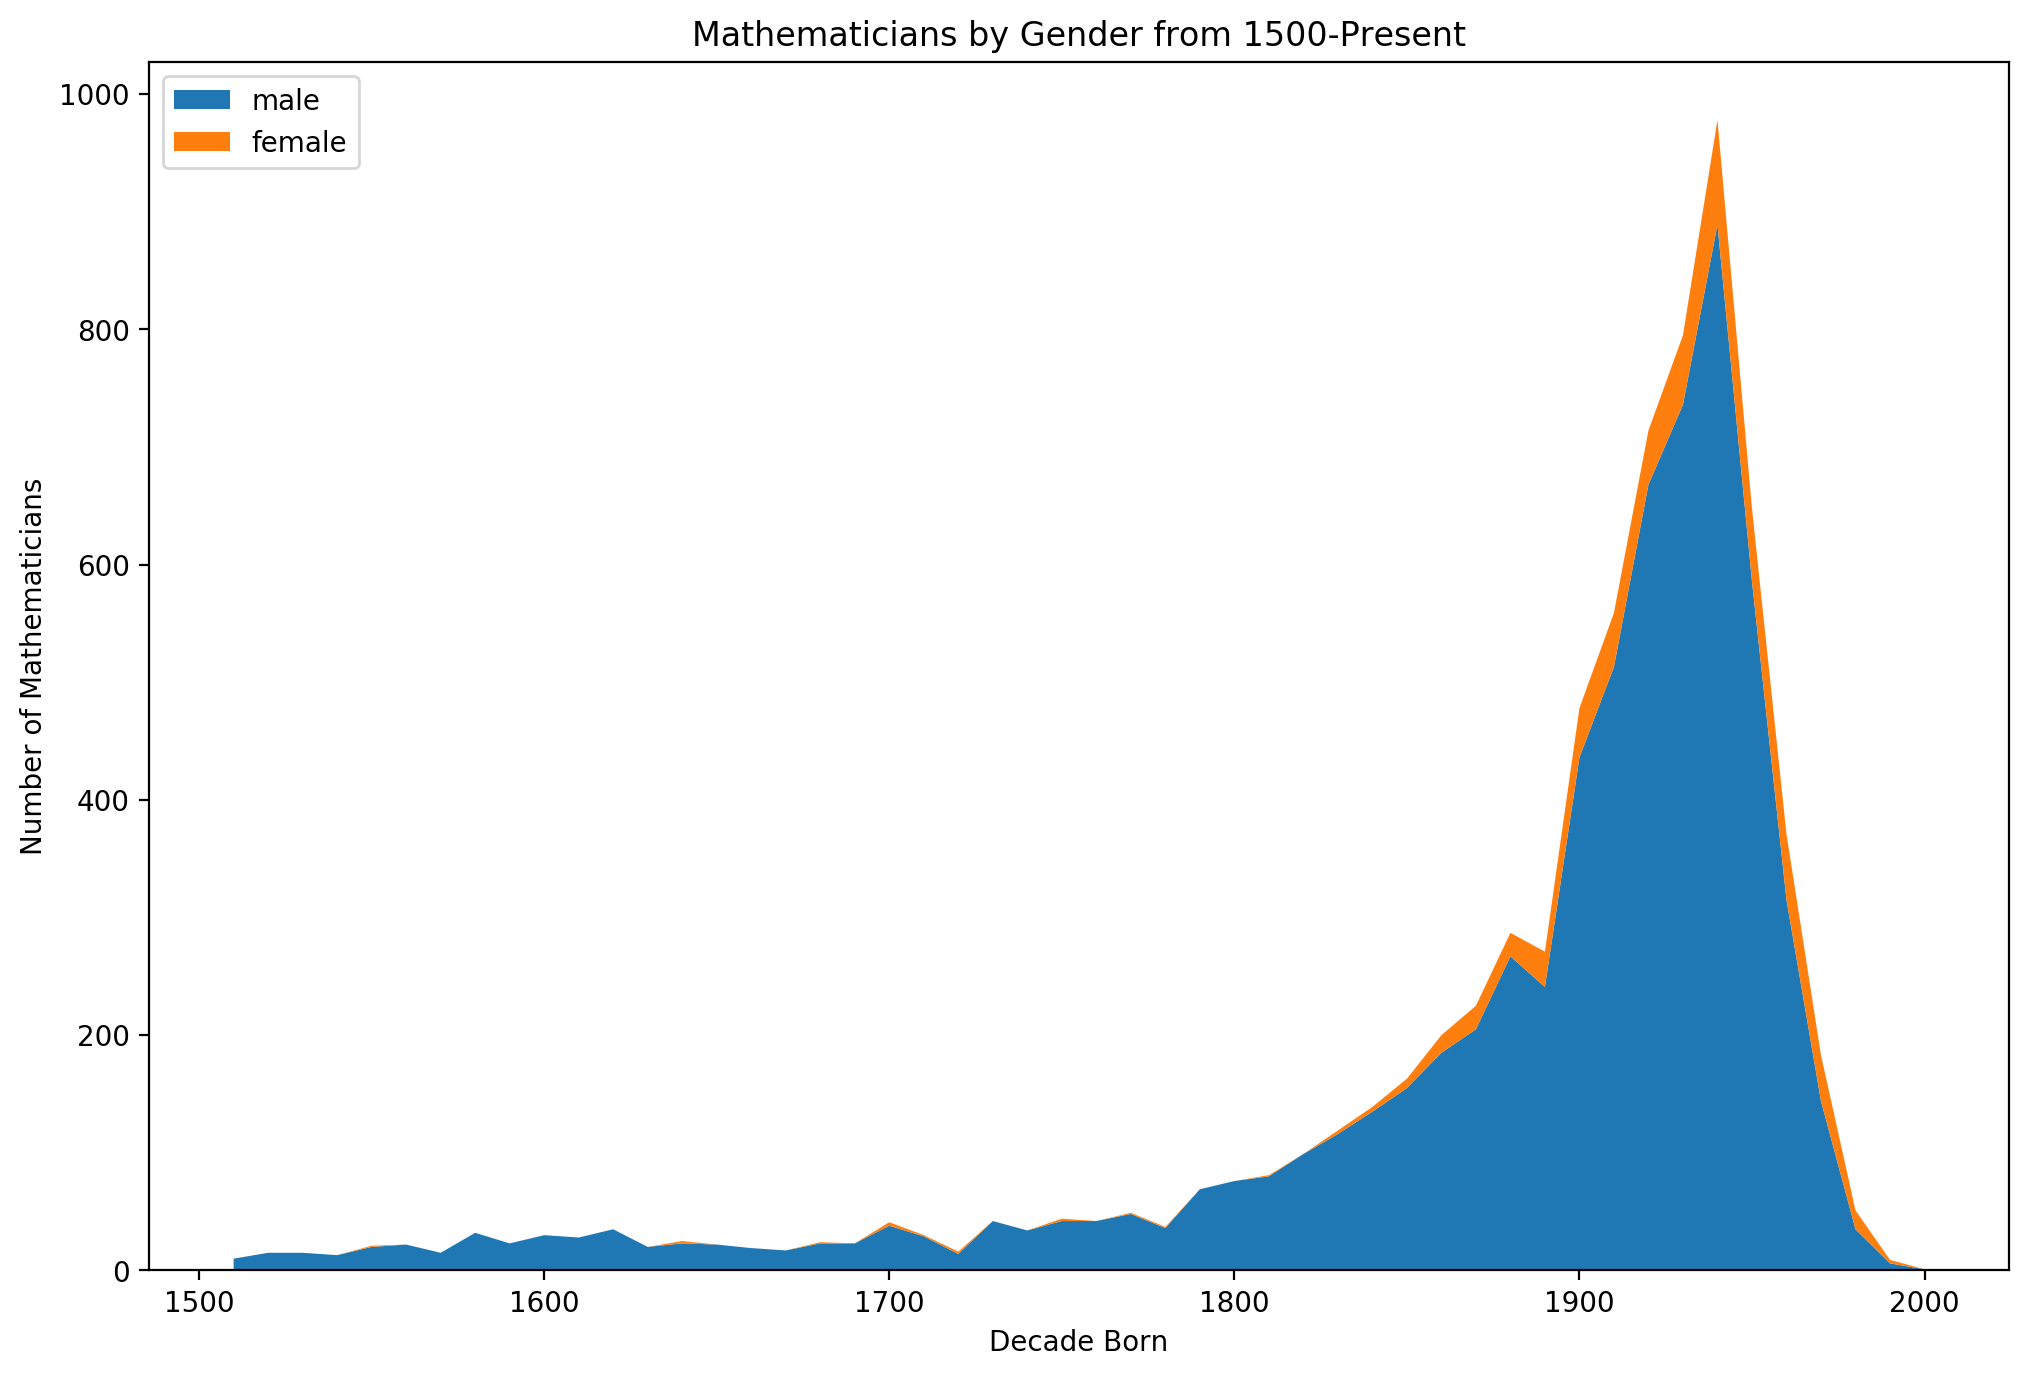

In [17]:
# plot proportion of women mathematicians
dates = birthFeats(df)
dates = dates[dates['decade born'] > 1500]
dates = dates.groupby(['decade born']).sum()
# dates['percent male'] = 100 * dates['male'] / (dates['male'] + dates['female'])

fig, ax = plt.subplots(figsize=(12, 8), dpi=200)
plt.stackplot(dates.index, dates[['male', 'female']].T, labels=['male', 'female'])
ax.set_xlabel('Decade Born')
ax.set_ylabel('Number of Mathematicians')
ax.set_title('Mathematicians by Gender from 1500-Present')
plt.legend(loc = 'upper left')
plt.show()

The proportion of mathematicians that are women appears to have remained approximately steady since 1850.

## Awards
Let's now investigate the mathematiciains who won prestigous awards.

In [18]:
# create functions to clean and extract information from text and listed columns
def cleanText(df, column):
    df[column] = df[column].str.replace("'", "")
    df[column] = df[column].str.replace("[", "")
    df[column] = df[column].str.replace("]", "")
    return df

def cleanList(df, column):
    df = cleanText(df, column)
    df[column] = df[column].str.split(', ')
    return df

def makeDummies(df, column, dummy_list):
    list_dummies = pd.DataFrame(columns=dummy_list, index=df.index)
    for dummy in dummy_list:
        for row in range(len(df[column])):
            for element in df[column].iloc[row]:
                if element == dummy:
                    list_dummies[dummy].iloc[row] = 1
                    break
                else:
                    list_dummies[dummy].iloc[row] = 0

    list_dummies = list_dummies.astype(int)
    df = pd.concat([df, list_dummies], axis=1)
    return df

Though math has no Nobel Prize, it has its fair share of prestigious awards and designations. The two most impressive are the **Abel Prize** and the **Fields Medal**. Other notable decorations include the Chern Medal, Kyoto Prize, Rolf Schock Prize, Turing Award, Nevanlinna Prize, Wolf Prize, and Carl Friedrich Gauss Medal.

Here, we'll briefly look into all of them.

In [19]:
# make features for the most prestigious awards in math
famous_awards = ['Fields Medal', 'Abel Prize', 'Turing Award',
                 'Wolf Prize', 'Carl Friedrich Gauss Medal',
                 'Nevanlinna Prize', 'Chern Medal', 'Kyoto Prize']

awards = df[df['award received'].notnull()].reset_index(drop=True)
awards = cleanList(awards, 'award received')
awards = makeDummies(awards, 'award received', famous_awards)

In [20]:
print('Famous awards and their number of recipients:')
print()
for i in famous_awards:
    print(i + ':', awards[awards[i]==1].shape[0])

Famous awards and their number of recipients:

Fields Medal: 56
Abel Prize: 18
Turing Award: 17
Wolf Prize: 15
Carl Friedrich Gauss Medal: 7
Nevanlinna Prize: 5
Chern Medal: 2
Kyoto Prize: 2


For easier analysis, we'll categorize these awards into broader groups (e.g. put all computer science awards together).

In [21]:
# Create Award Sub-Groups
prestigious_award = awards[(awards['Fields Medal']==1) | (awards['Abel Prize']==1) |
                           (awards['Chern Medal']==1) | (awards['Kyoto Prize']==1) |
                           (awards['Turing Award']==1) | (awards['Nevanlinna Prize']==1) |
                           (awards['Wolf Prize']==1) | 
                           (awards['Carl Friedrich Gauss Medal']==1)].reset_index(drop=True)

fields_medal = awards[awards['Fields Medal']==1].reset_index(drop=True)
CS_awards = awards[(awards['Turing Award']==1) | (awards['Nevanlinna Prize']==1)].reset_index(drop=True)
application_prizes = awards[(awards['Kyoto Prize']==1) | (awards['Carl Friedrich Gauss Medal']==1)].reset_index(drop=True)

print('Prestigious Award Winners:', prestigious_award.shape[0])
print('Fields Medal Winners:', fields_medal.shape[0])
print('Computer Science Award Winners:', CS_awards.shape[0])
print('Applications of Math Award Winners:', application_prizes.shape[0])

Prestigious Award Winners: 109
Fields Medal Winners: 56
Computer Science Award Winners: 22
Applications of Math Award Winners: 9


In [22]:
fields_medal = birthFeats(fields_medal)
prestigious_award = birthFeats(prestigious_award)
CS_awards = birthFeats(CS_awards)
application_prizes = birthFeats(application_prizes)

occupations = occupations[occupations['occupation'] != 'professor'].reset_index(drop=True)

Next we'll try to understand the professions of the recipients, how they vary between award, and how they've changed over time. 

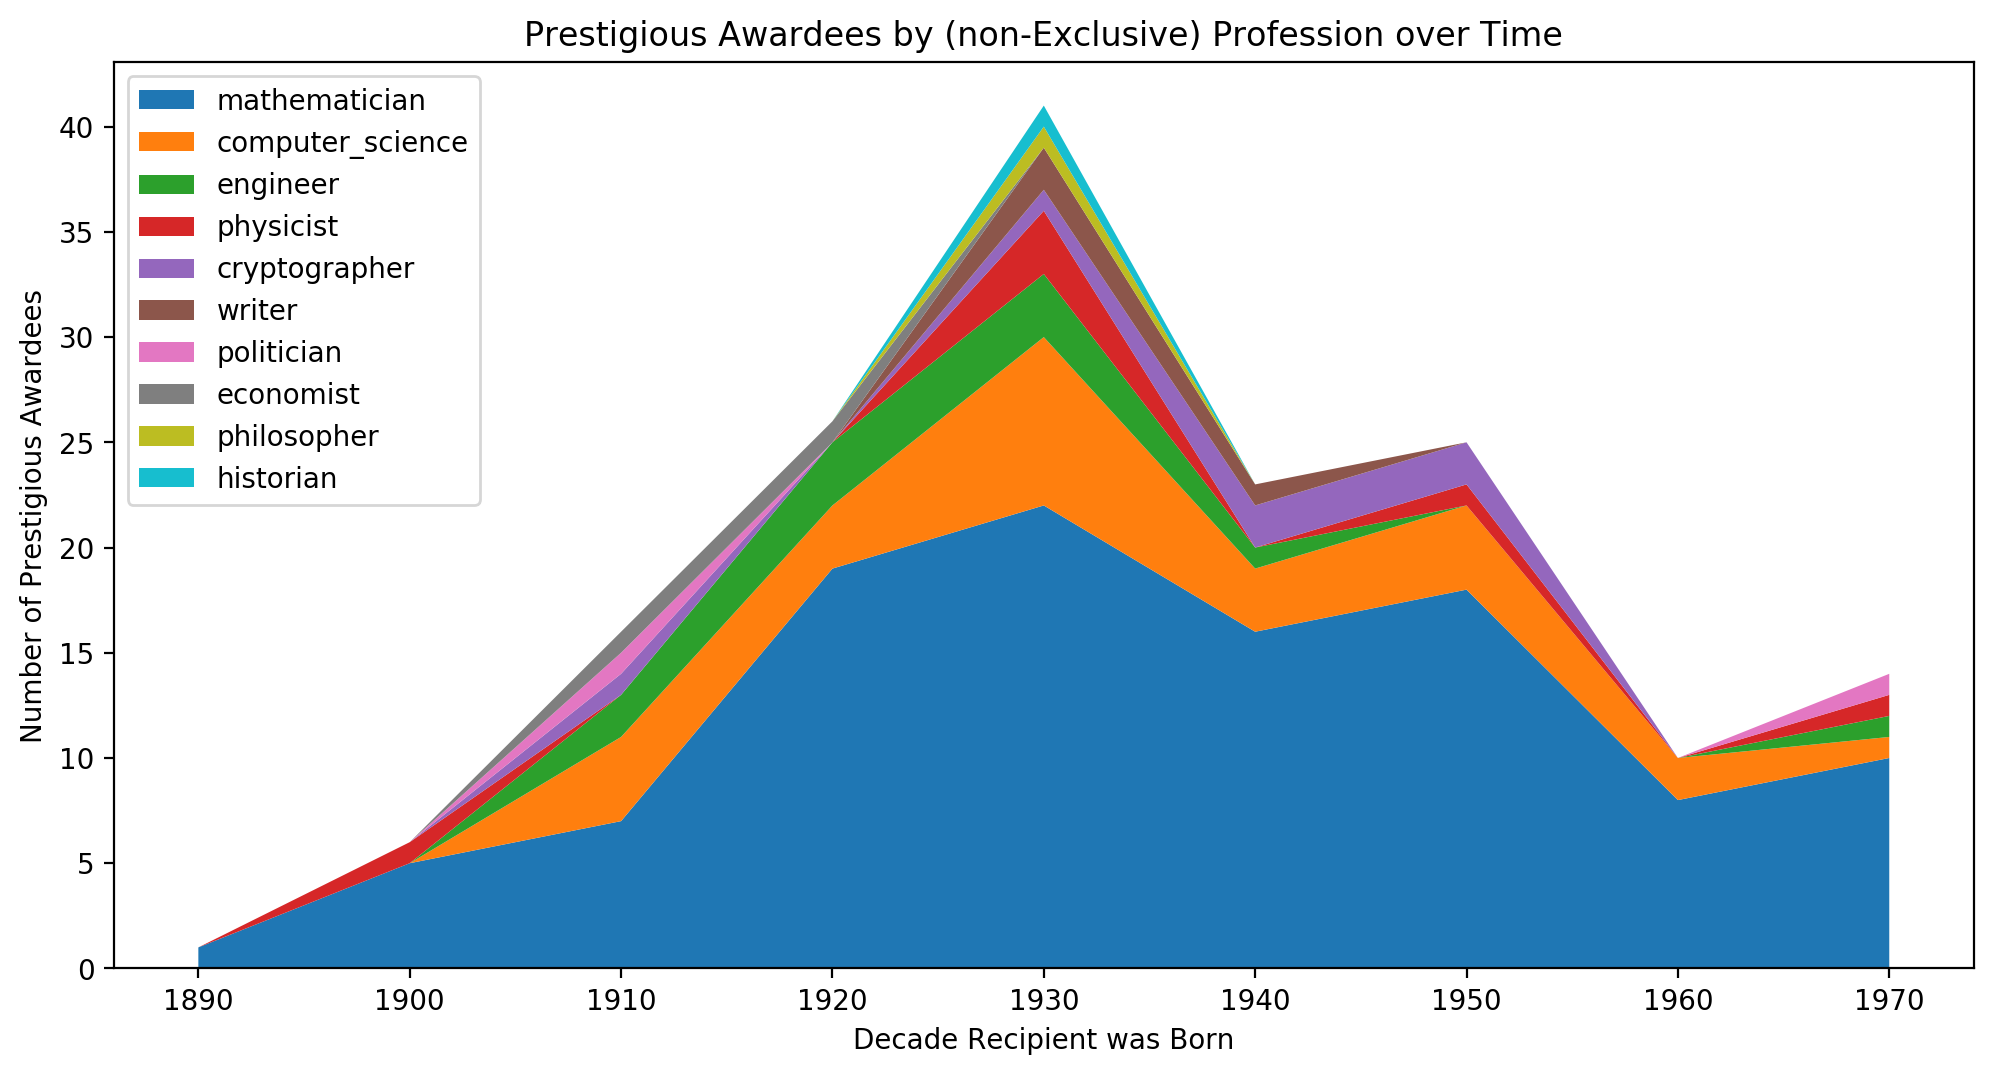

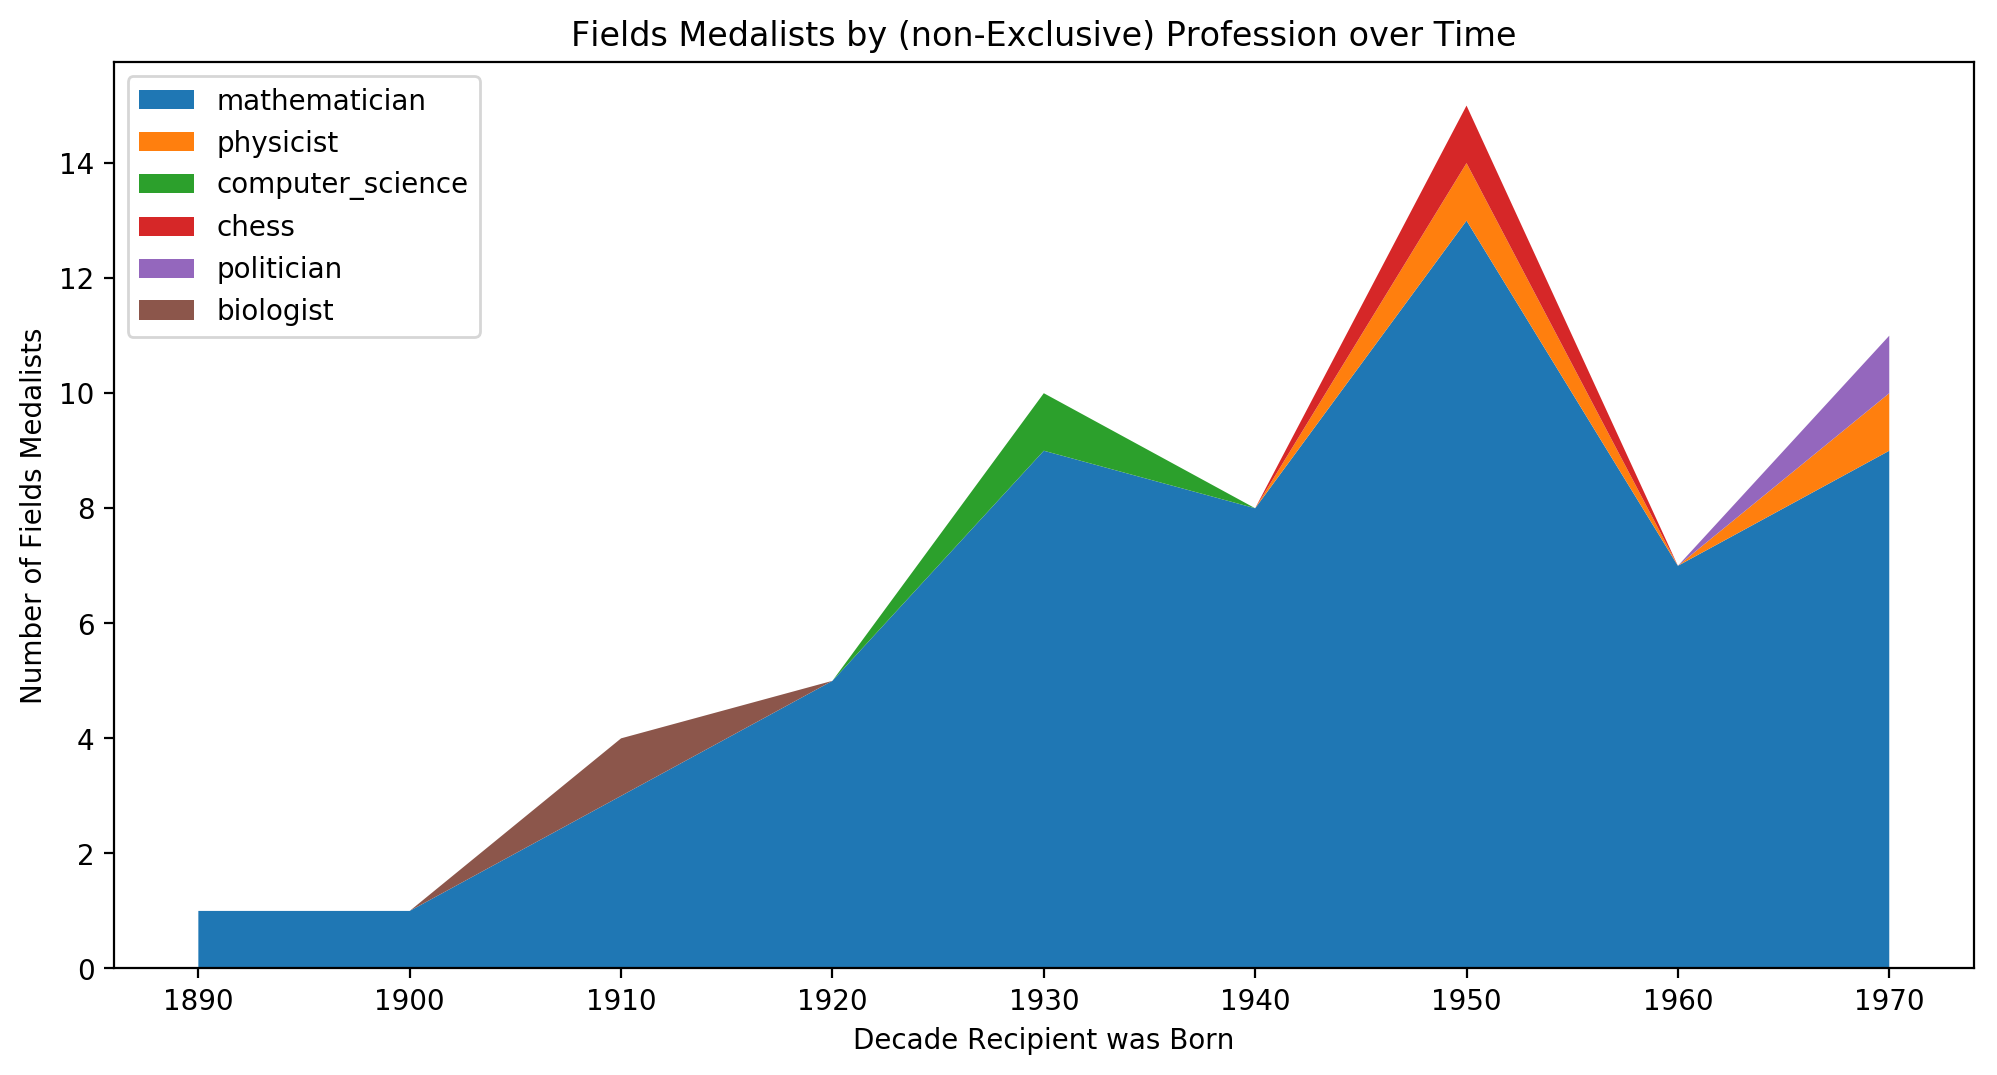

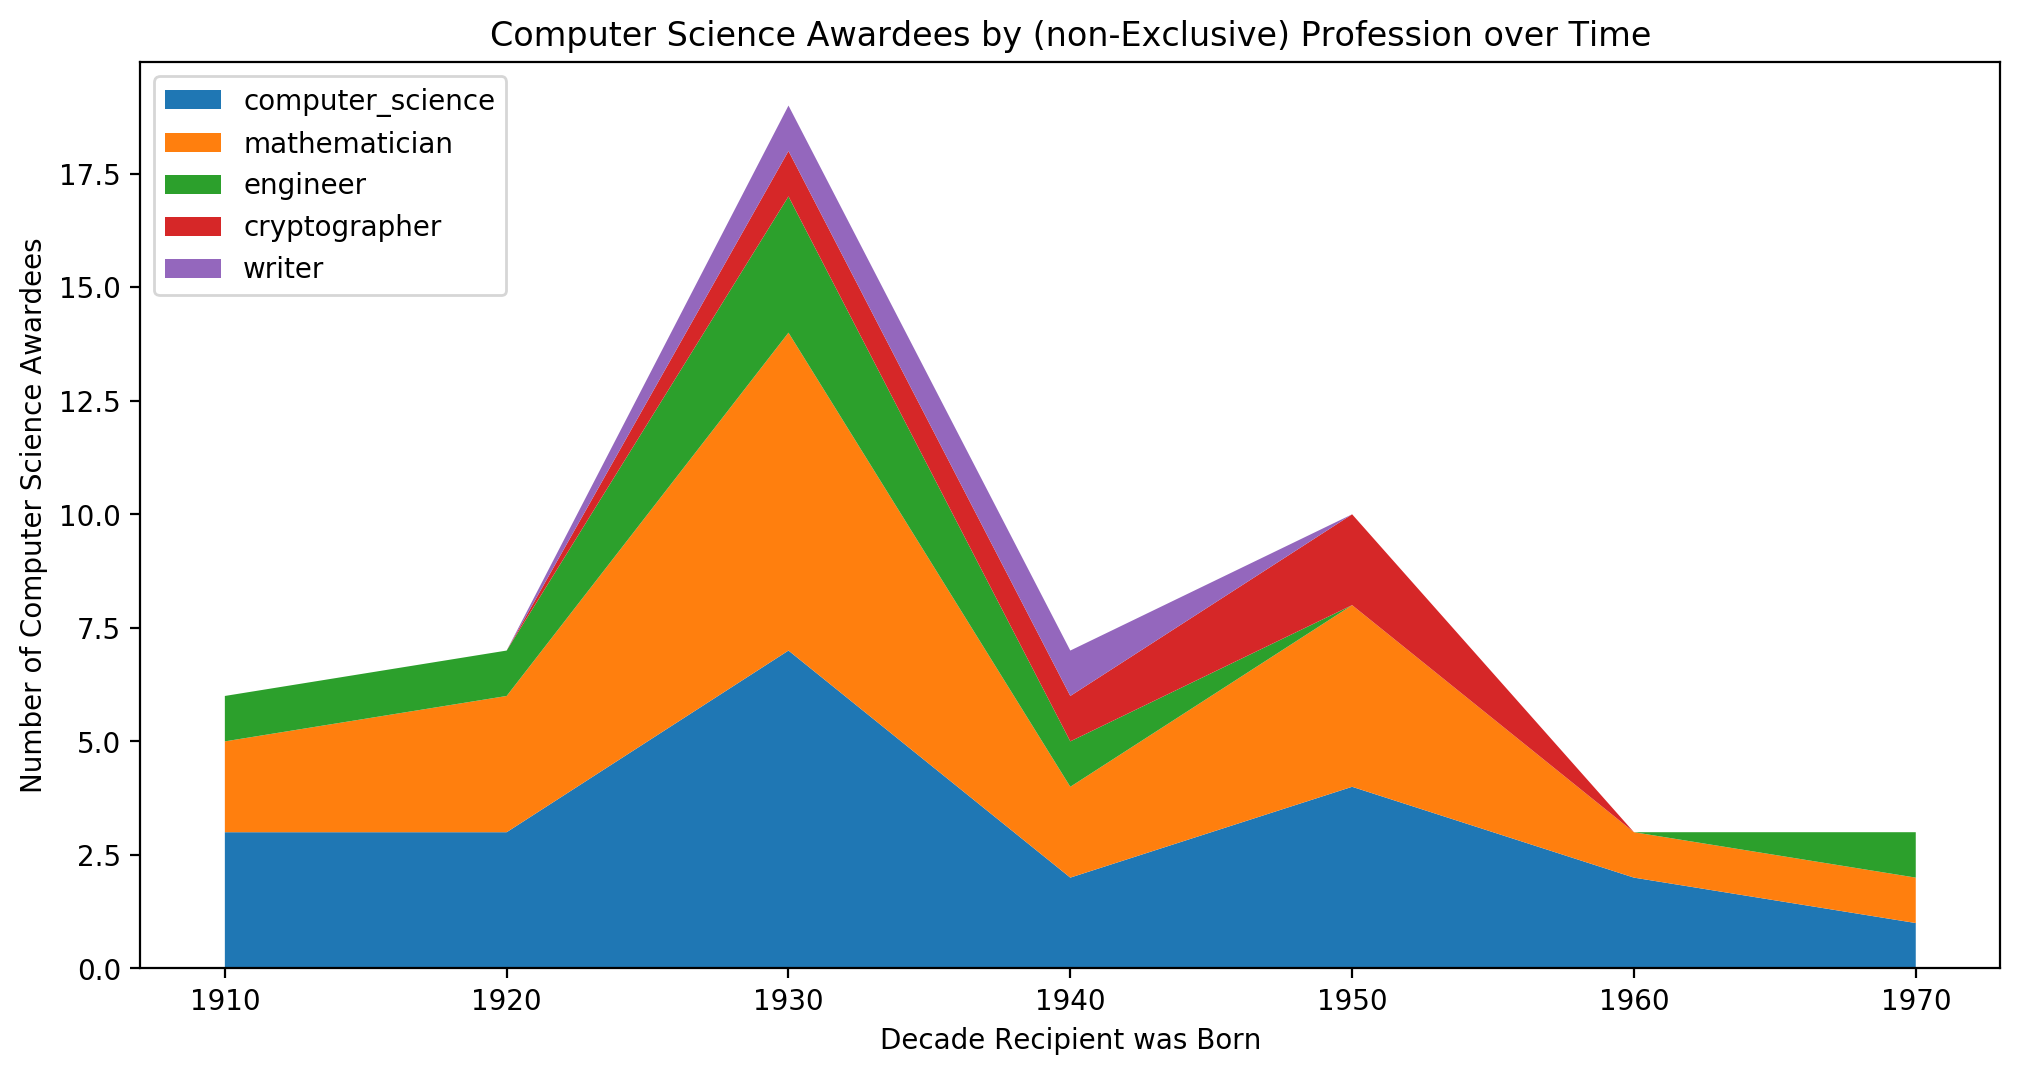

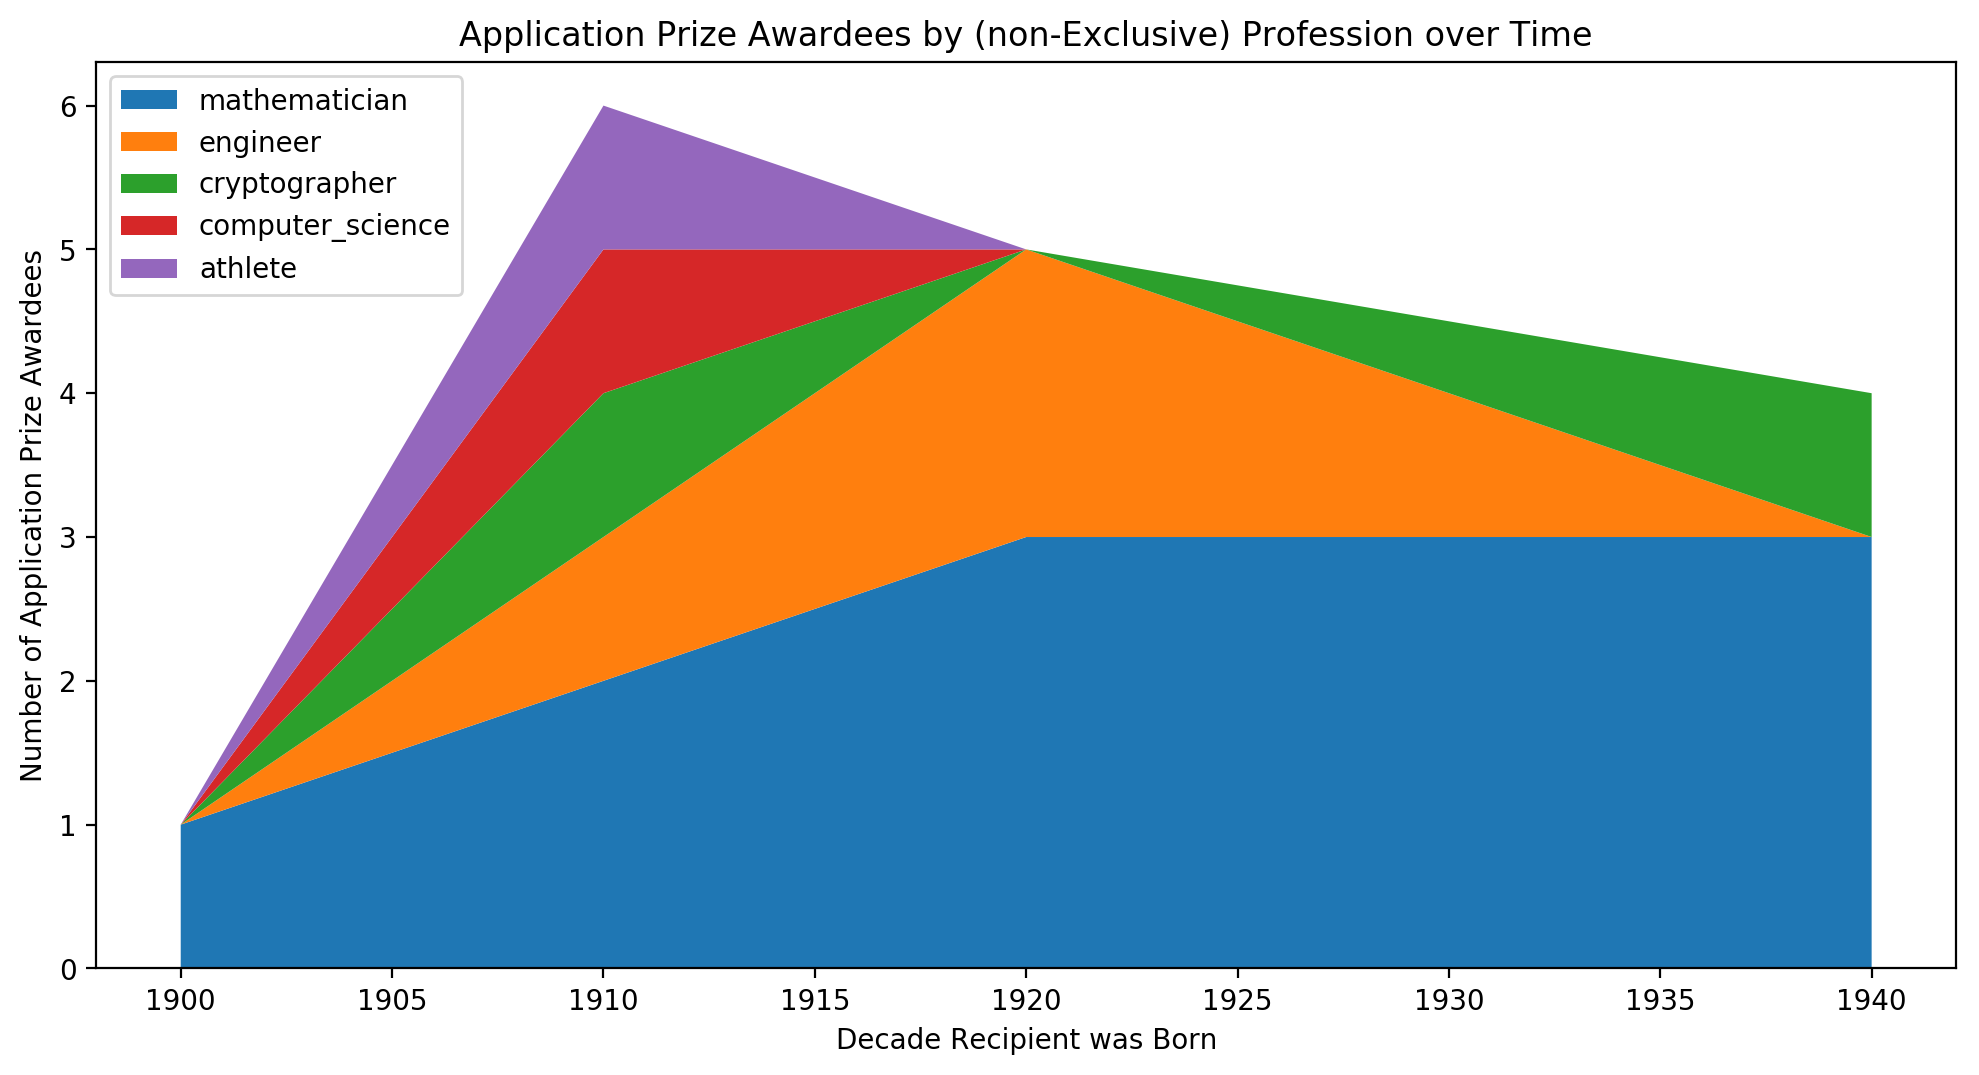

In [23]:
# plot professions of prestigious award
prestigious_award = prestigious_award.groupby(['decade born']).sum()
prestigious_award = prestigious_award[[i for i in occupations['occupation']]]
columns = prestigious_award.sum().T.sort_values(ascending=False)[:10]
prestigious_award = prestigious_award[columns.index]
decades = prestigious_award.index

fig, ax = plt.subplots(figsize=(12, 6), dpi=200)
ax.stackplot(decades, prestigious_award.T, labels=columns.index)
ax.set_xlabel('Decade Recipient was Born')
ax.set_ylabel('Number of Prestigious Awardees')
ax.set_title('Prestigious Awardees by (non-Exclusive) Profession over Time')
plt.legend(loc = 'upper left')
plt.show()


# plot professions of fields medal
fields_medal = fields_medal.groupby(['decade born']).sum()
fields_medal = fields_medal[[i for i in occupations['occupation']]]
columns = fields_medal.sum().T.sort_values(ascending=False)[:6]
fields_medal = fields_medal[columns.index]
decades = fields_medal.index

fig, ax = plt.subplots(figsize=(12, 6), dpi=200)
ax.stackplot(decades, fields_medal.T, labels=columns.index)
ax.set_xlabel('Decade Recipient was Born')
ax.set_ylabel('Number of Fields Medalists')
ax.set_title('Fields Medalists by (non-Exclusive) Profession over Time')
plt.legend(loc = 'upper left')
plt.show()


# plot professions of computer science awards
CS_awards = CS_awards.groupby(['decade born']).sum()
CS_awards = CS_awards[[i for i in occupations['occupation']]]
columns = CS_awards.sum().T.sort_values(ascending=False)[:5]
CS_awards = CS_awards[columns.index]
decades = CS_awards.index

fig, ax = plt.subplots(figsize=(12, 6), dpi=200)
ax.stackplot(decades, CS_awards.T, labels=columns.index)
ax.set_xlabel('Decade Recipient was Born')
ax.set_ylabel('Number of Computer Science Awardees')
ax.set_title('Computer Science Awardees by (non-Exclusive) Profession over Time')
plt.legend(loc = 'upper left')
plt.show()


# plot professions of math application awards
application_prizes = application_prizes.groupby(['decade born']).sum()
application_prizes = application_prizes[[i for i in occupations['occupation']]]
columns = application_prizes.sum().T.sort_values(ascending=False)[:5]
application_prizes = application_prizes[columns.index]
decades = application_prizes.index

fig, ax = plt.subplots(figsize=(12, 6), dpi=200)
ax.stackplot(decades, application_prizes.T, labels=columns.index)
ax.set_xlabel('Decade Recipient was Born')
ax.set_ylabel('Number of Application Prize Awardees')
ax.set_title('Application Prize Awardees by (non-Exclusive) Profession over Time')
plt.legend(loc = 'upper left')
plt.show()

Intuitively, these distributions make sense. The Fields Medal rewards mathematical excellence and significant contribution to pure math -- professional mathematicials *should* be the winning overwhelmingly. On the other hand, computer science and mathematical application prizes are more likely to be won by a wider cadre of mathematicians than pure theoreticians and professors. Indeed, we see computer scientists, cryptographers, and engineers doing especially well in these contests.

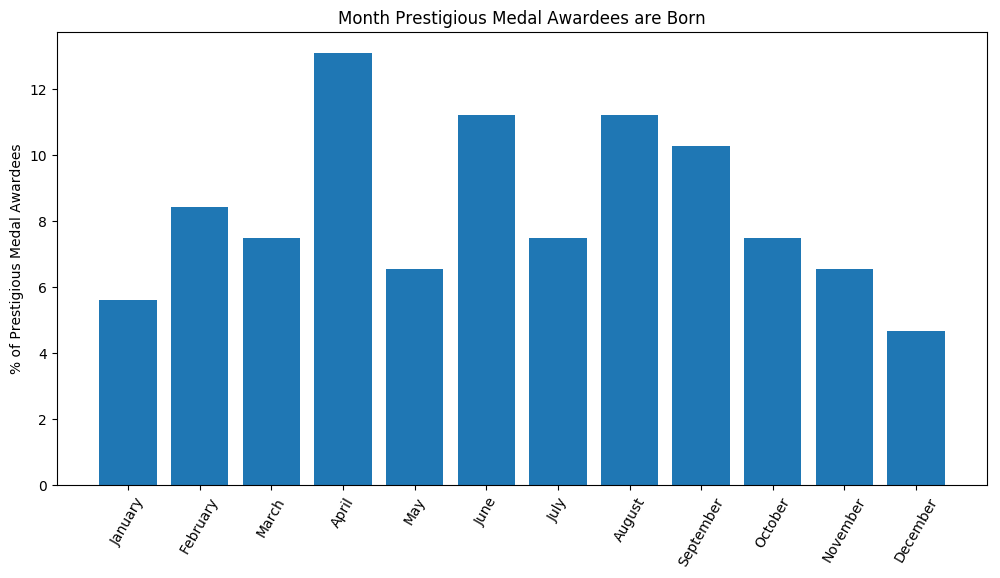

In [24]:
# plot prestigious award winners by month born
prestigious_award = awards[(awards['Fields Medal']==1) | (awards['Abel Prize']==1) |
                           (awards['Chern Medal']==1) | (awards['Kyoto Prize']==1) |
                           (awards['Turing Award']==1) | (awards['Nevanlinna Prize']==1) |
                           (awards['Wolf Prize']==1) | 
                           (awards['Carl Friedrich Gauss Medal']==1)].reset_index(drop=True)

prestigious_award = birthFeats(prestigious_award)

month_data = prestigious_award[prestigious_award['month of birth'].notnull()].reset_index(drop=True)

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December']

values = []
total = month_data['mathematicians'].loc[month_data['month of birth'].notnull()].count()

for i in months:
    value = month_data['mathematicians'].loc[month_data['month of birth'] == i].count()
    values.append(value / total * 100)

fig = plt.figure(figsize=(12, 6))
plt.bar(range(len(months)), values, align='center')
plt.xticks(range(len(months)), months, rotation=60)
plt.ylabel('% of Prestigious Medal Awardees')
plt.title('Month Prestigious Medal Awardees are Born')
plt.show()

Upon first glance, it looks like month of birth plays may play a role in winning a prestigious math award. However, this may just be coincidence. With our small sample size divided over twelve months, randomness has a large impact. If we imagine birth months instead grouped by season, the bar graph would look more equitable. Still, winter would be lower than summer, so maybe there is some cognitive or social advantage to being born when it's warm.

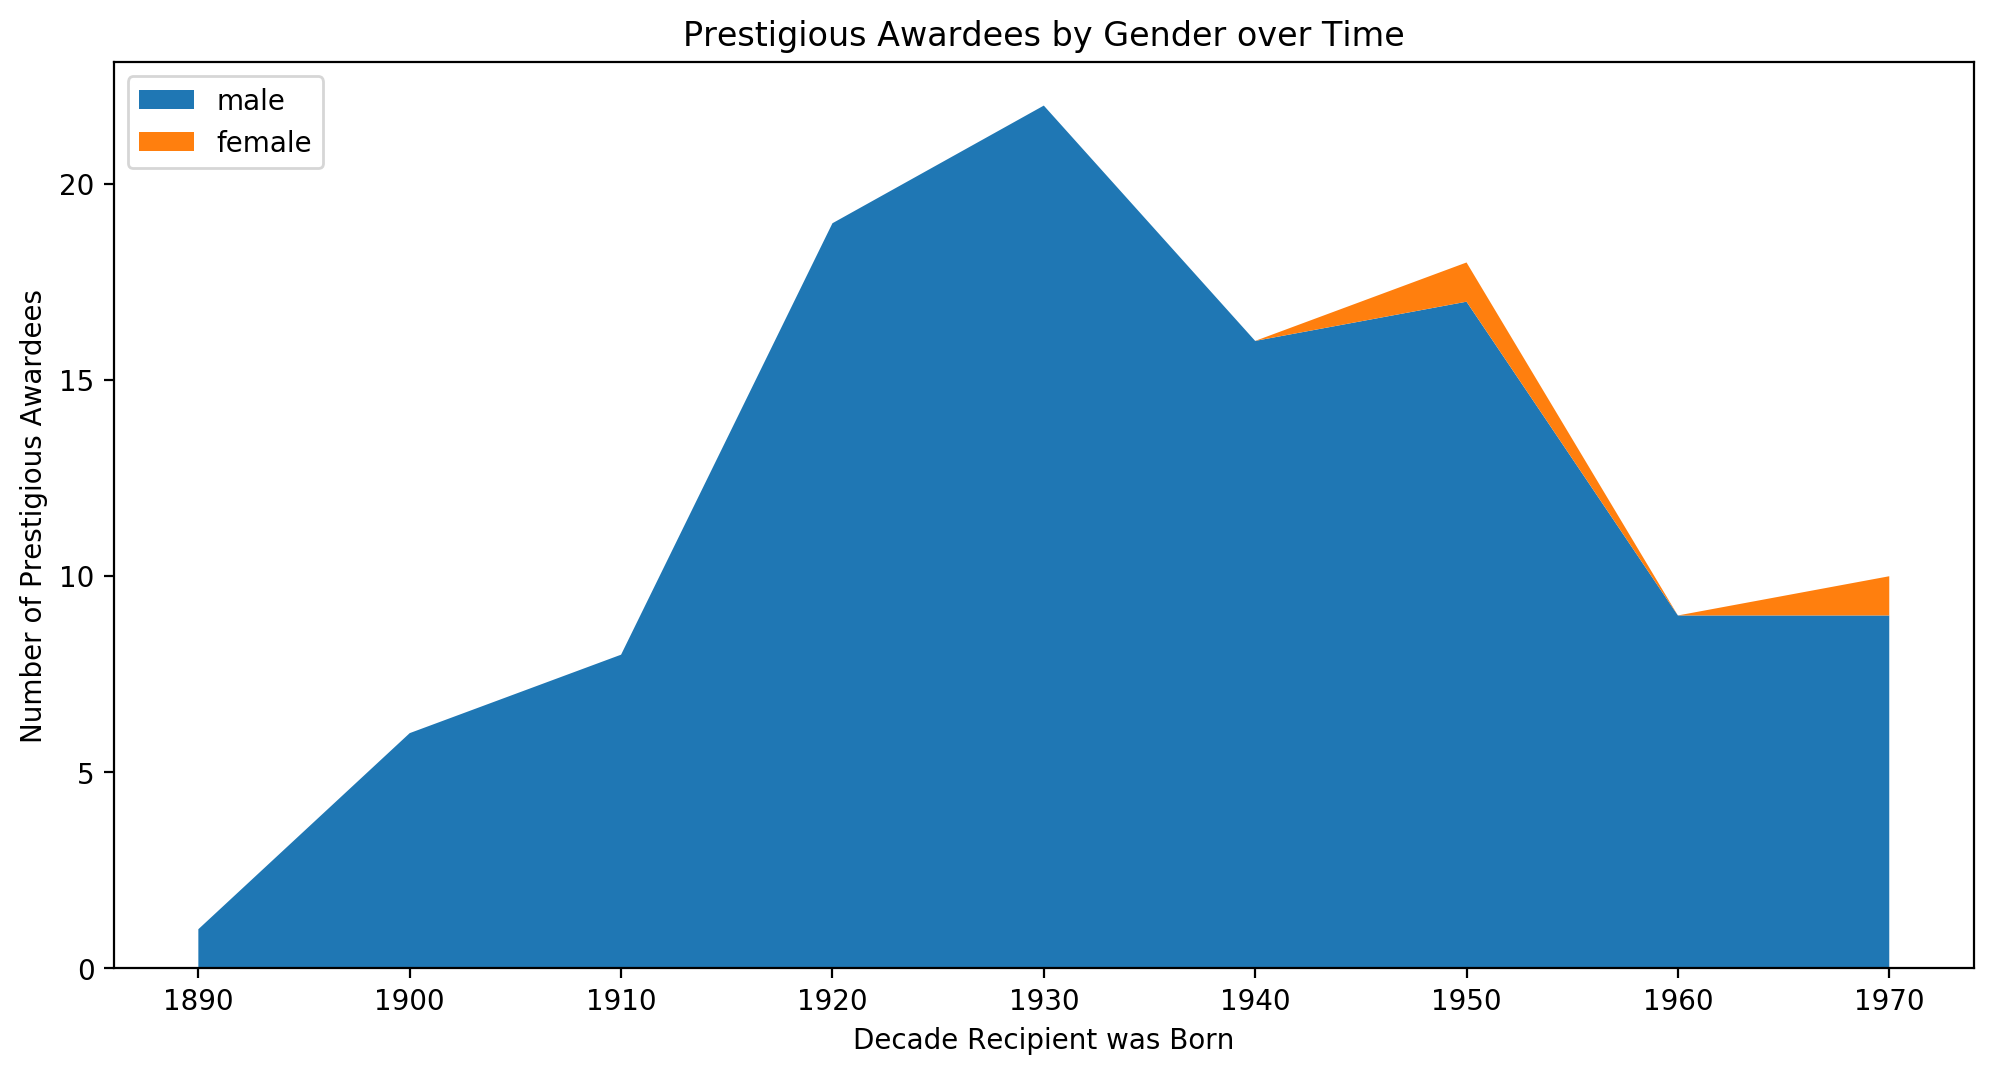

In [25]:
# plot prestigious award recipients by gender over time
prestigious_award = awards[(awards['Fields Medal']==1) | (awards['Abel Prize']==1) |
                           (awards['Chern Medal']==1) | (awards['Kyoto Prize']==1) |
                           (awards['Turing Award']==1) | (awards['Nevanlinna Prize']==1) |
                           (awards['Wolf Prize']==1) | 
                           (awards['Carl Friedrich Gauss Medal']==1)].reset_index(drop=True)

prestigious_award = birthFeats(prestigious_award)
prestigious_award = prestigious_award.groupby(['decade born']).sum()
prestigious_award = prestigious_award[['male', 'female']]

fig, ax = plt.subplots(figsize=(12, 6), dpi=200)
ax.stackplot(prestigious_award.index, prestigious_award.T, labels=['male', 'female'])
ax.set_xlabel('Decade Recipient was Born')
ax.set_ylabel('Number of Prestigious Awardees')
ax.set_title('Prestigious Awardees by Gender over Time')
plt.legend(loc = 'upper left')
plt.show()

Women have only recently begun winning the most prestigious awards in math despite representing approximately the same proportion of mathematicians since 1850. 

### Fields Medalists
Let's now further investigate Fields Medalists. Specifically, let's see what areas of math they've contributed to and how that's changed over time.

In [26]:
# create function to extract dummy variables from a list column
def getDummyList(df, column):
    dummy_list = list(set([element for row in cleanList(df, column)[column] for element in row]))
    return dummy_list

In [27]:
# extract dummies from Fields Medalists' "field of work" column
fields_medal = awards[awards['Fields Medal']==1].reset_index(drop=True)
fields_medal = birthFeats(fields_medal)

fields_medal = fields_medal[fields_medal['field of work'].notnull()]
dummy_list = getDummyList(fields_medal, 'field of work')
fields_medal = makeDummies(fields_medal, 'field of work', dummy_list).reset_index(drop=True)

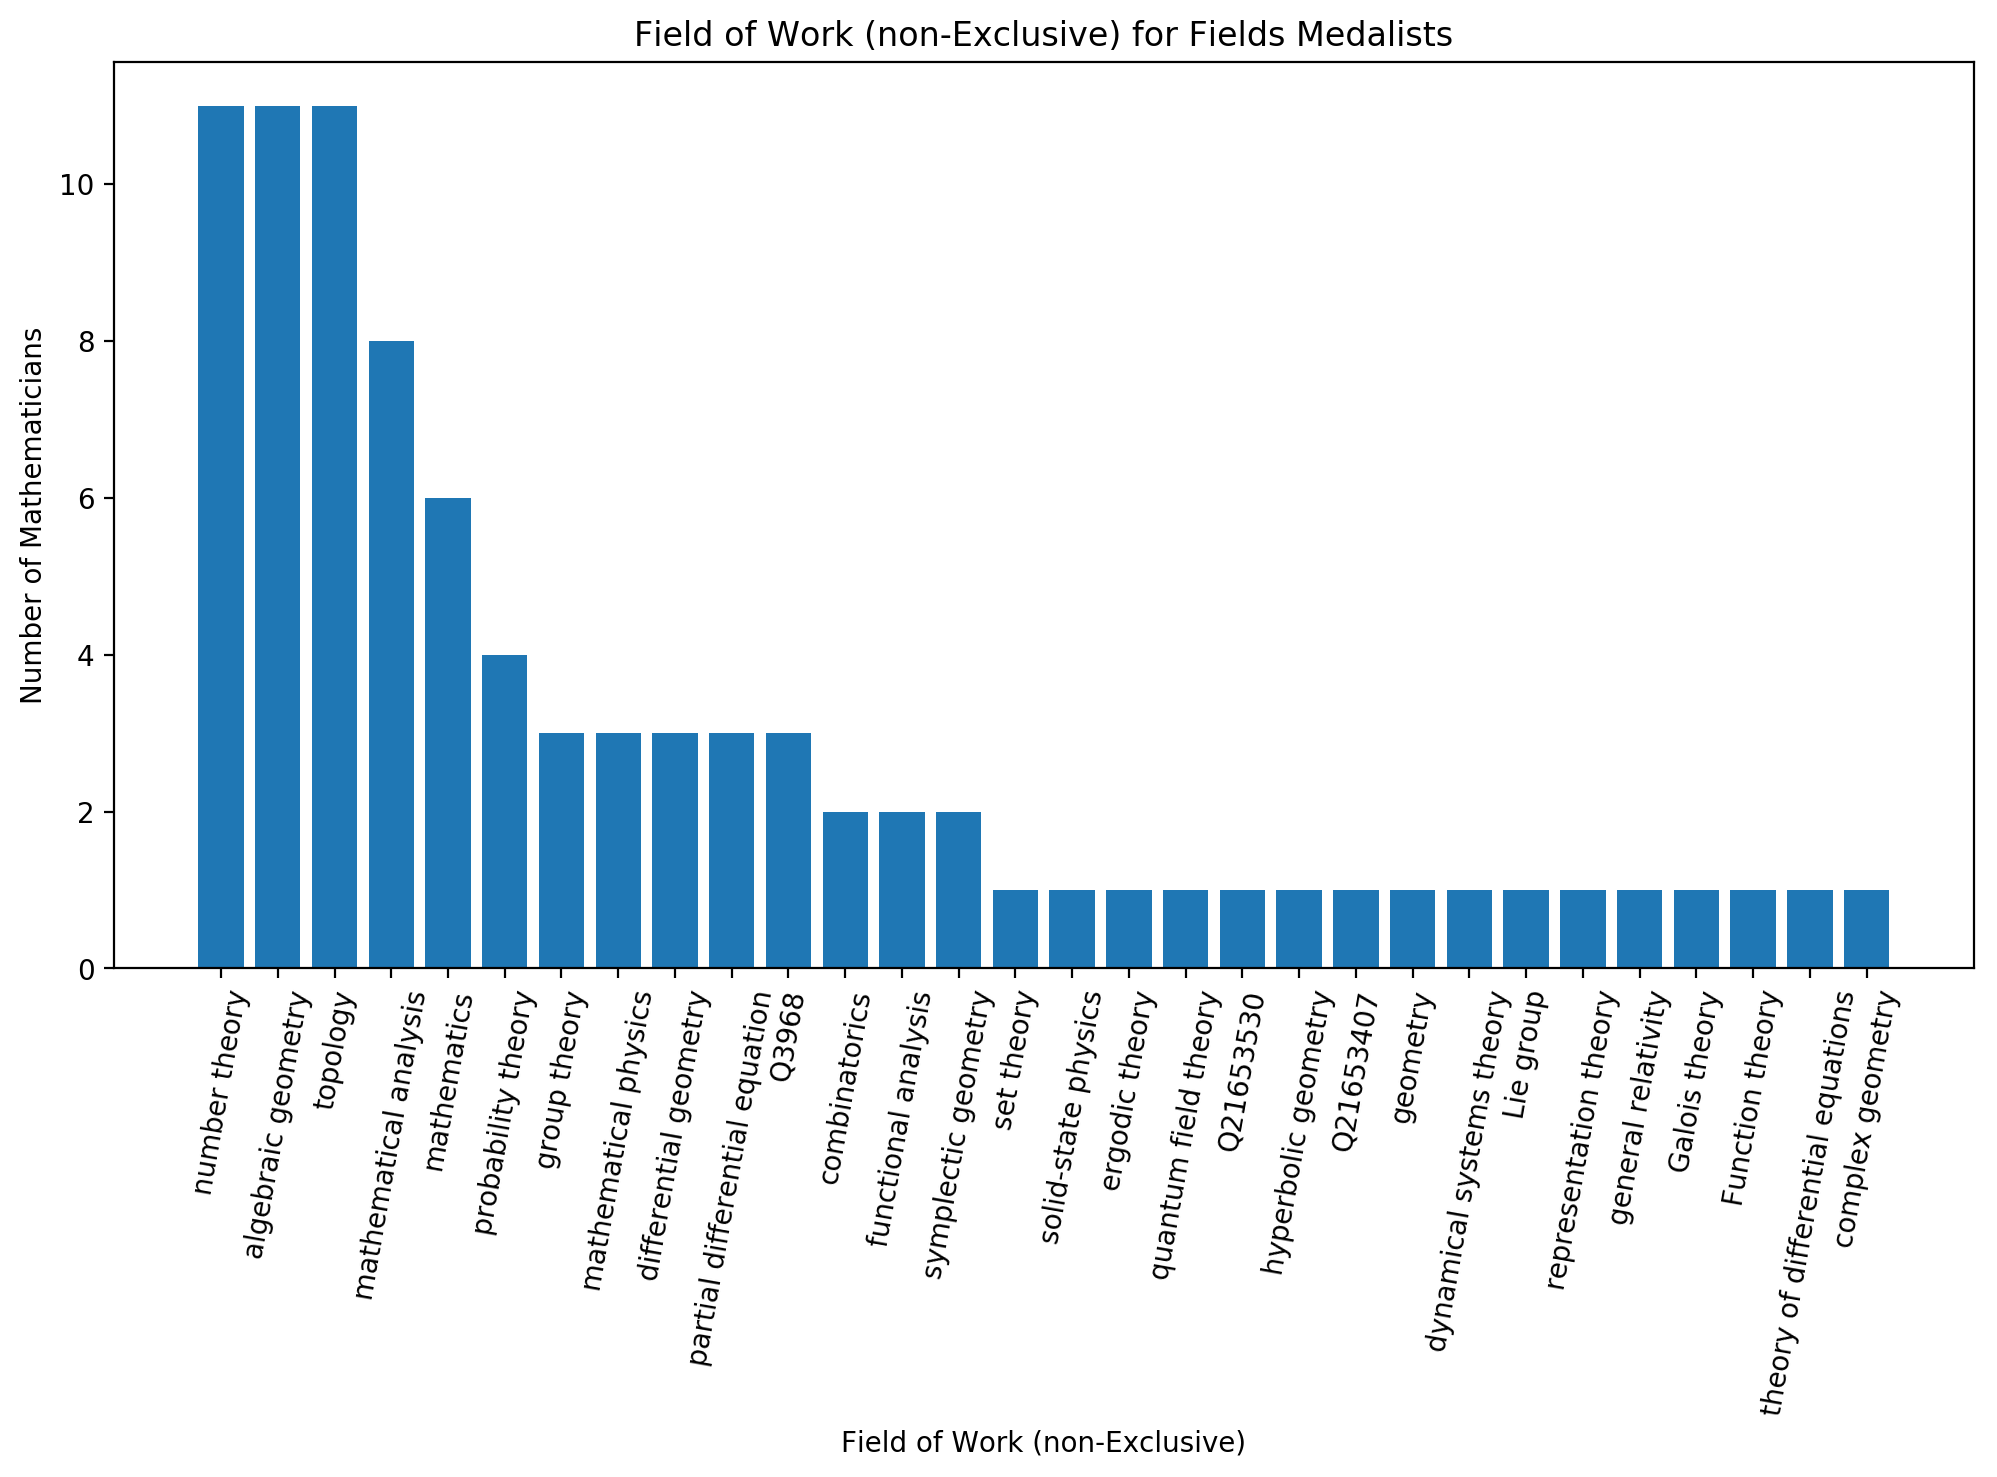

In [28]:
# plot the distribution of fields of work for Fields Medalists
n1 = 30
n2 = 30
n3 = 8
fields_medal_df = fields_medal[dummy_list]
columns = fields_medal_df.sum().sort_values(ascending=False)[:n1].index.tolist()
counts = fields_medal_df.sum().sort_values(ascending=False)[:n1].tolist()

plt.figure(figsize=(12, 6), dpi=200)
plt.bar(np.arange(len(counts)), counts, align='center', ecolor='black')
plt.xticks(range(len(counts)), columns, rotation=80)
plt.xlabel('Field of Work (non-Exclusive)')
plt.ylabel('Number of Mathematicians')
plt.title('Field of Work (non-Exclusive) for Fields Medalists')
plt.show()

Topology, number theory, algebraic geometry, and mathemtical analysis appear to be the "hottest" research fields for winning a Fields Medal. 

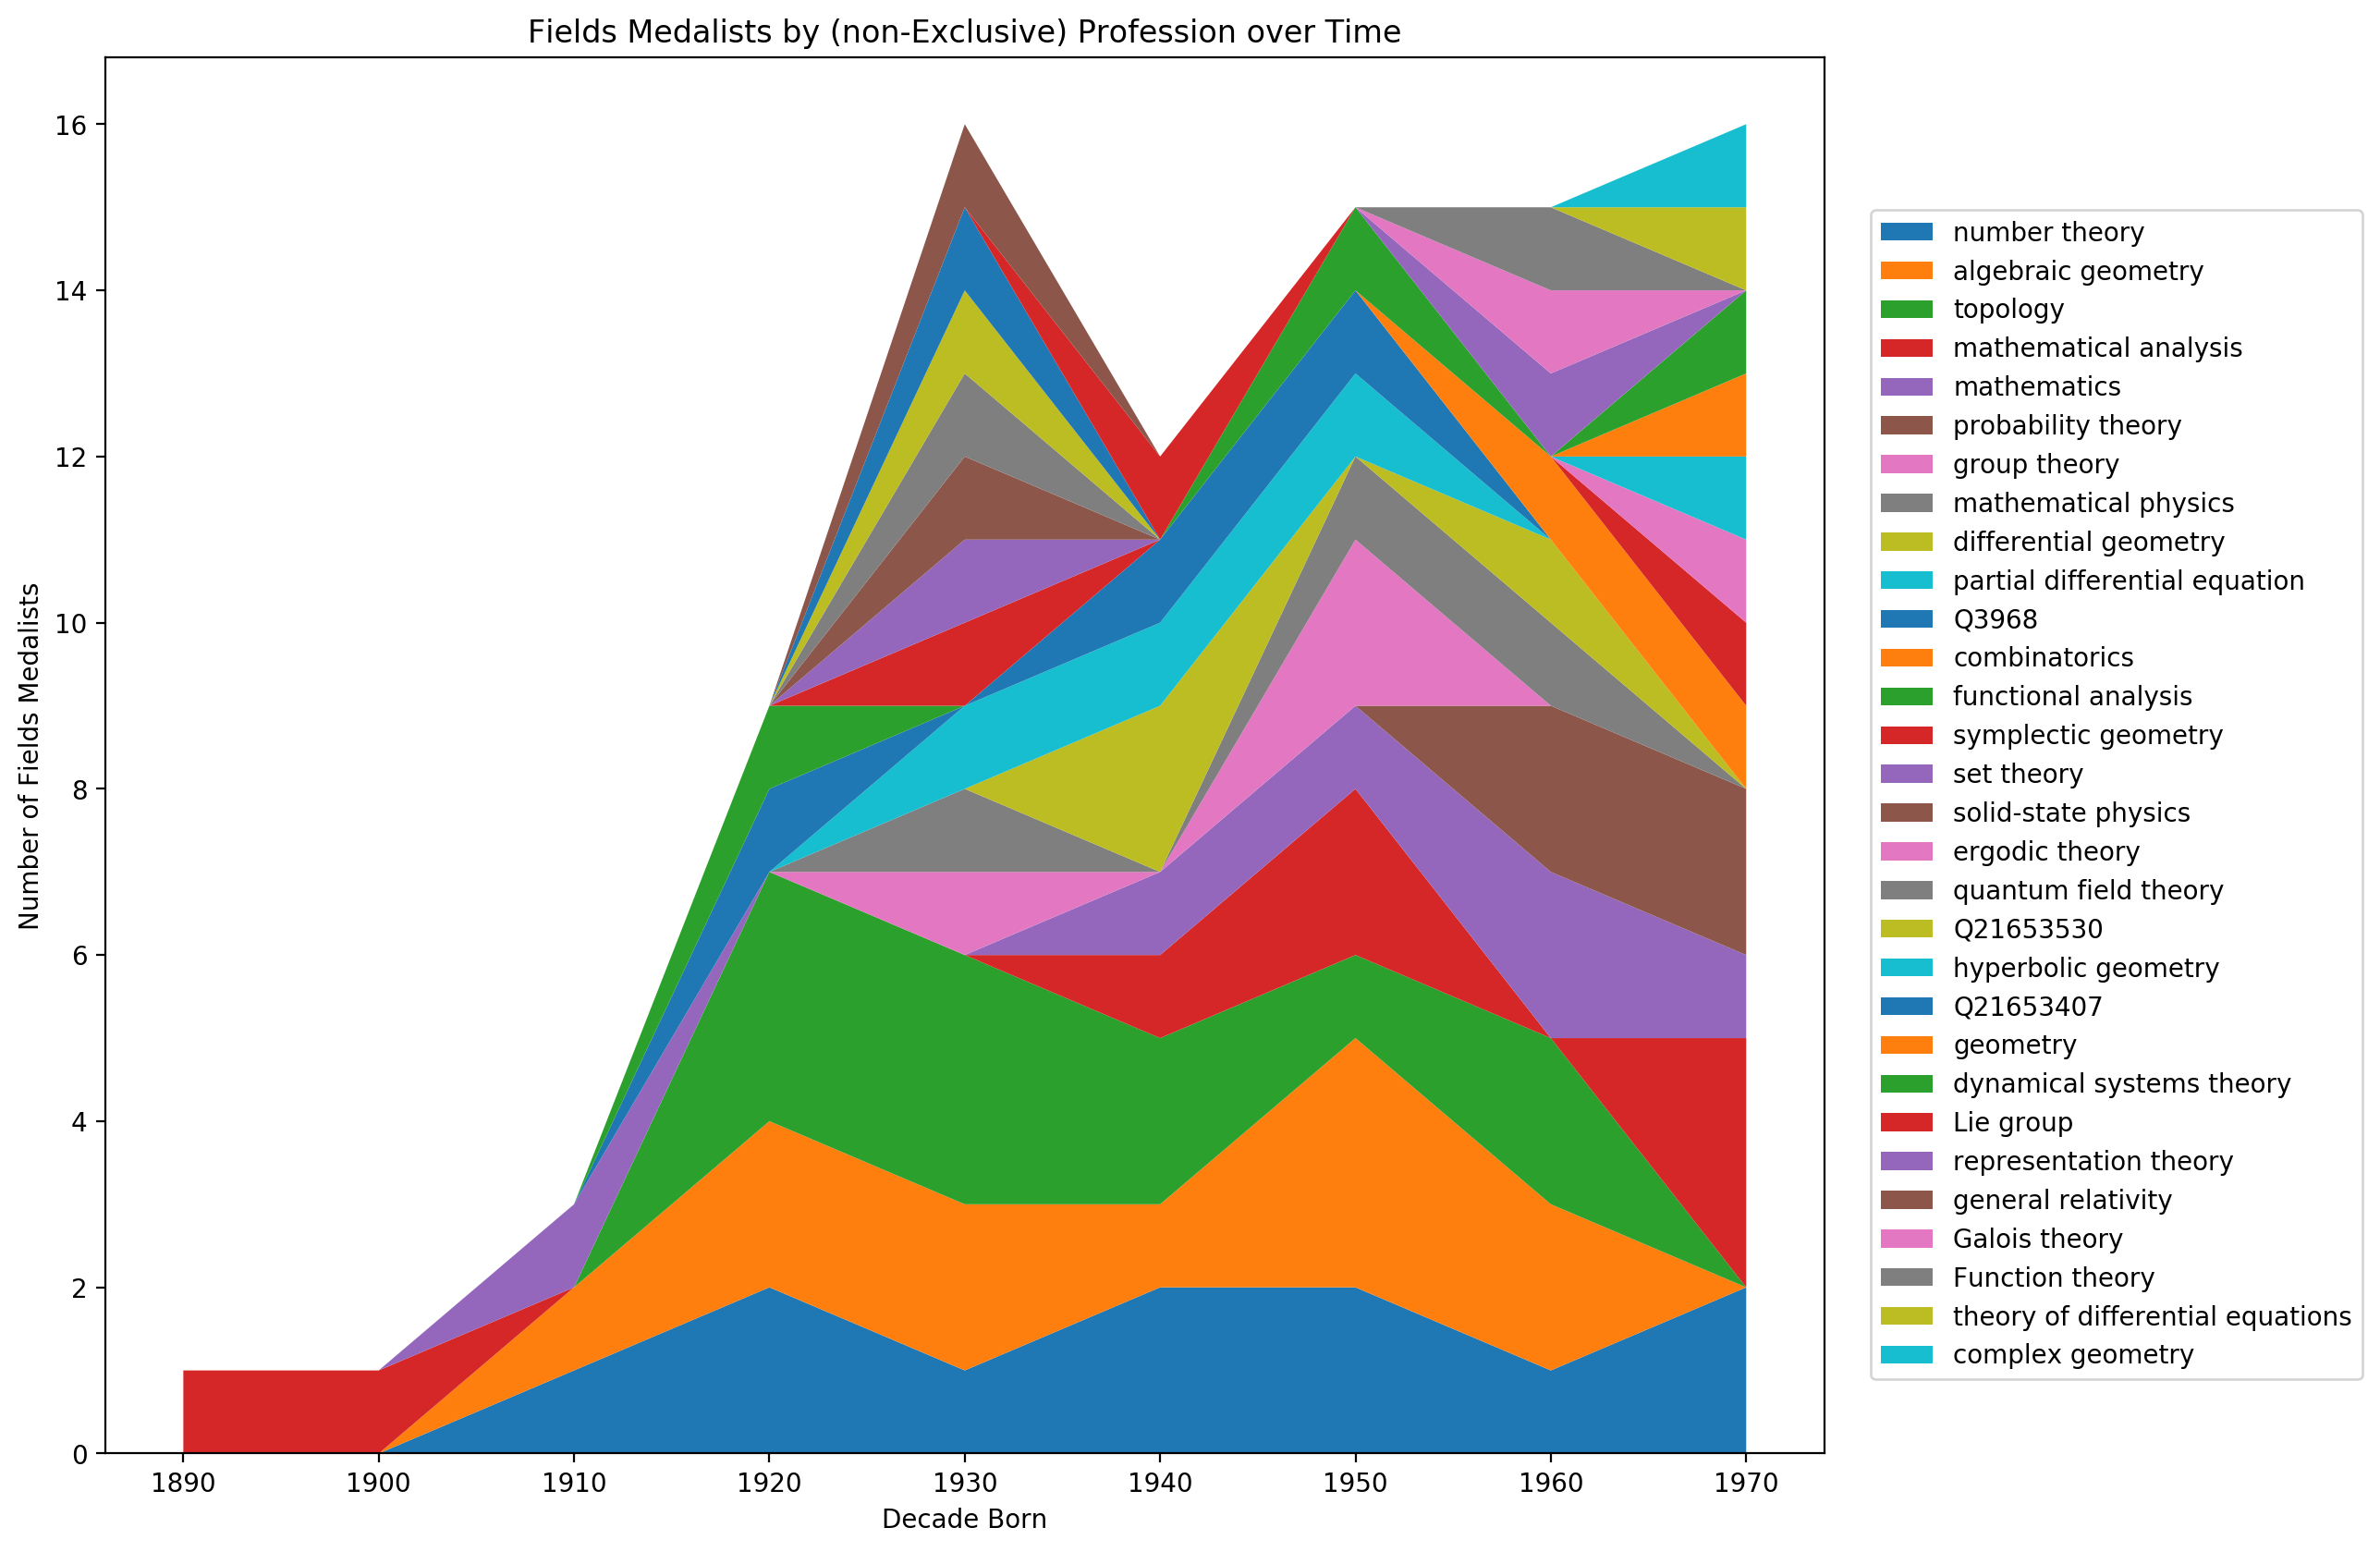

In [29]:
# plot fields of research for fields medalists over time
fields_medal_grouped = fields_medal.groupby(['decade born']).sum()
fields_medal_grouped = fields_medal_grouped[columns[:n2]]
decades = fields_medal_grouped.index

fig, ax = plt.subplots(figsize=(12, 10), dpi=200)
ax.stackplot(decades, fields_medal_grouped.T, labels=columns)
ax.set_xlabel('Decade Born')
ax.set_ylabel('Number of Fields Medalists')
ax.set_title('Fields Medalists by (non-Exclusive) Profession over Time')
plt.legend(loc=9, bbox_to_anchor=(1.17, .9))
plt.show()

Fields Medal mathematicians born from 1890-1920 mainly worked in mathematical analysis, number theory, algebraic geometry, and topology. However, the mathematicians born during 1920-1930s won their Fields Medals by contributing to a much more diverse array of fields, many related to the development of physics (e.g. topology, number theory, algebraic geometry, mathematical physics, group theory, solid-state physics, lie groups, general relativity, quantum field theory, set theory, and symplectic geometry).

The mathematicians born in 1930-1940s converged to studying the traditional Field Medal fields, but those born in the 1950s-1970s again diverged, making large contributions to ergodic theory, dynamical systems theory, Galois theory, complex geeometry, repesentation theory, Lie groups, differential equations, function theory, hyberbolic geoemtry, combinatorics, and probability theory.

## Royal Society

From Wikipedia:

The "Royal Society, is a learned society for science and is possibly the oldest such society still in existence. Founded in November 1660, it was granted a royal charter by King Charles II as "The Royal Society". The Society is the United Kingdom's and Commonwealth of Nations' Academy of Sciences and fulfills a number of roles; promoting science and its benefits, recognising excellence in science, supporting outstanding science, providing scientific advice for policy, fostering international and global co-operation, education and public engagement."

In [30]:
# clean "member of" column
membership = df[df['member of'].notnull()].reset_index(drop=True)
membership = cleanList(membership, 'member of')
membership = makeDummies(membership, 'member of', ['Royal Society'])

In [31]:
royal_society = membership[membership['Royal Society'] == 1]

print('Confirmed Royal Society Members:', len(royal_society))
print('Confirmed Mathematicians in a Group or Society:', len(membership))
print('Mathematicians in data:', len(df))
print()
print('Royal Society members comprises', str((len(royal_society) / len(df))*100)[:4] + '% of total mathematicians in the dataset,')
print('and', str((len(royal_society) / len(membership))*100)[:5] + '% of mathematicians in a group or society.')

Confirmed Royal Society Members: 624
Confirmed Mathematicians in a Group or Society: 3091
Mathematicians in data: 8596

Royal Society members comprises 7.25% of total mathematicians in the dataset,
and 20.18% of mathematicians in a group or society.


In [32]:
# Find Professions of Royal Society
royal_society = royal_society[royal_society['field of work'].notnull()]
dummy_list = getDummyList(royal_society, 'field of work')
royal_society = makeDummies(royal_society, 'field of work', dummy_list)
royal_society = birthFeats(royal_society).reset_index(drop=True)

royal_society_df = royal_society[dummy_list]
royal_society_grouped = royal_society.groupby(royal_society['decade born']).sum()
royal_society_grouped = royal_society_grouped[dummy_list]

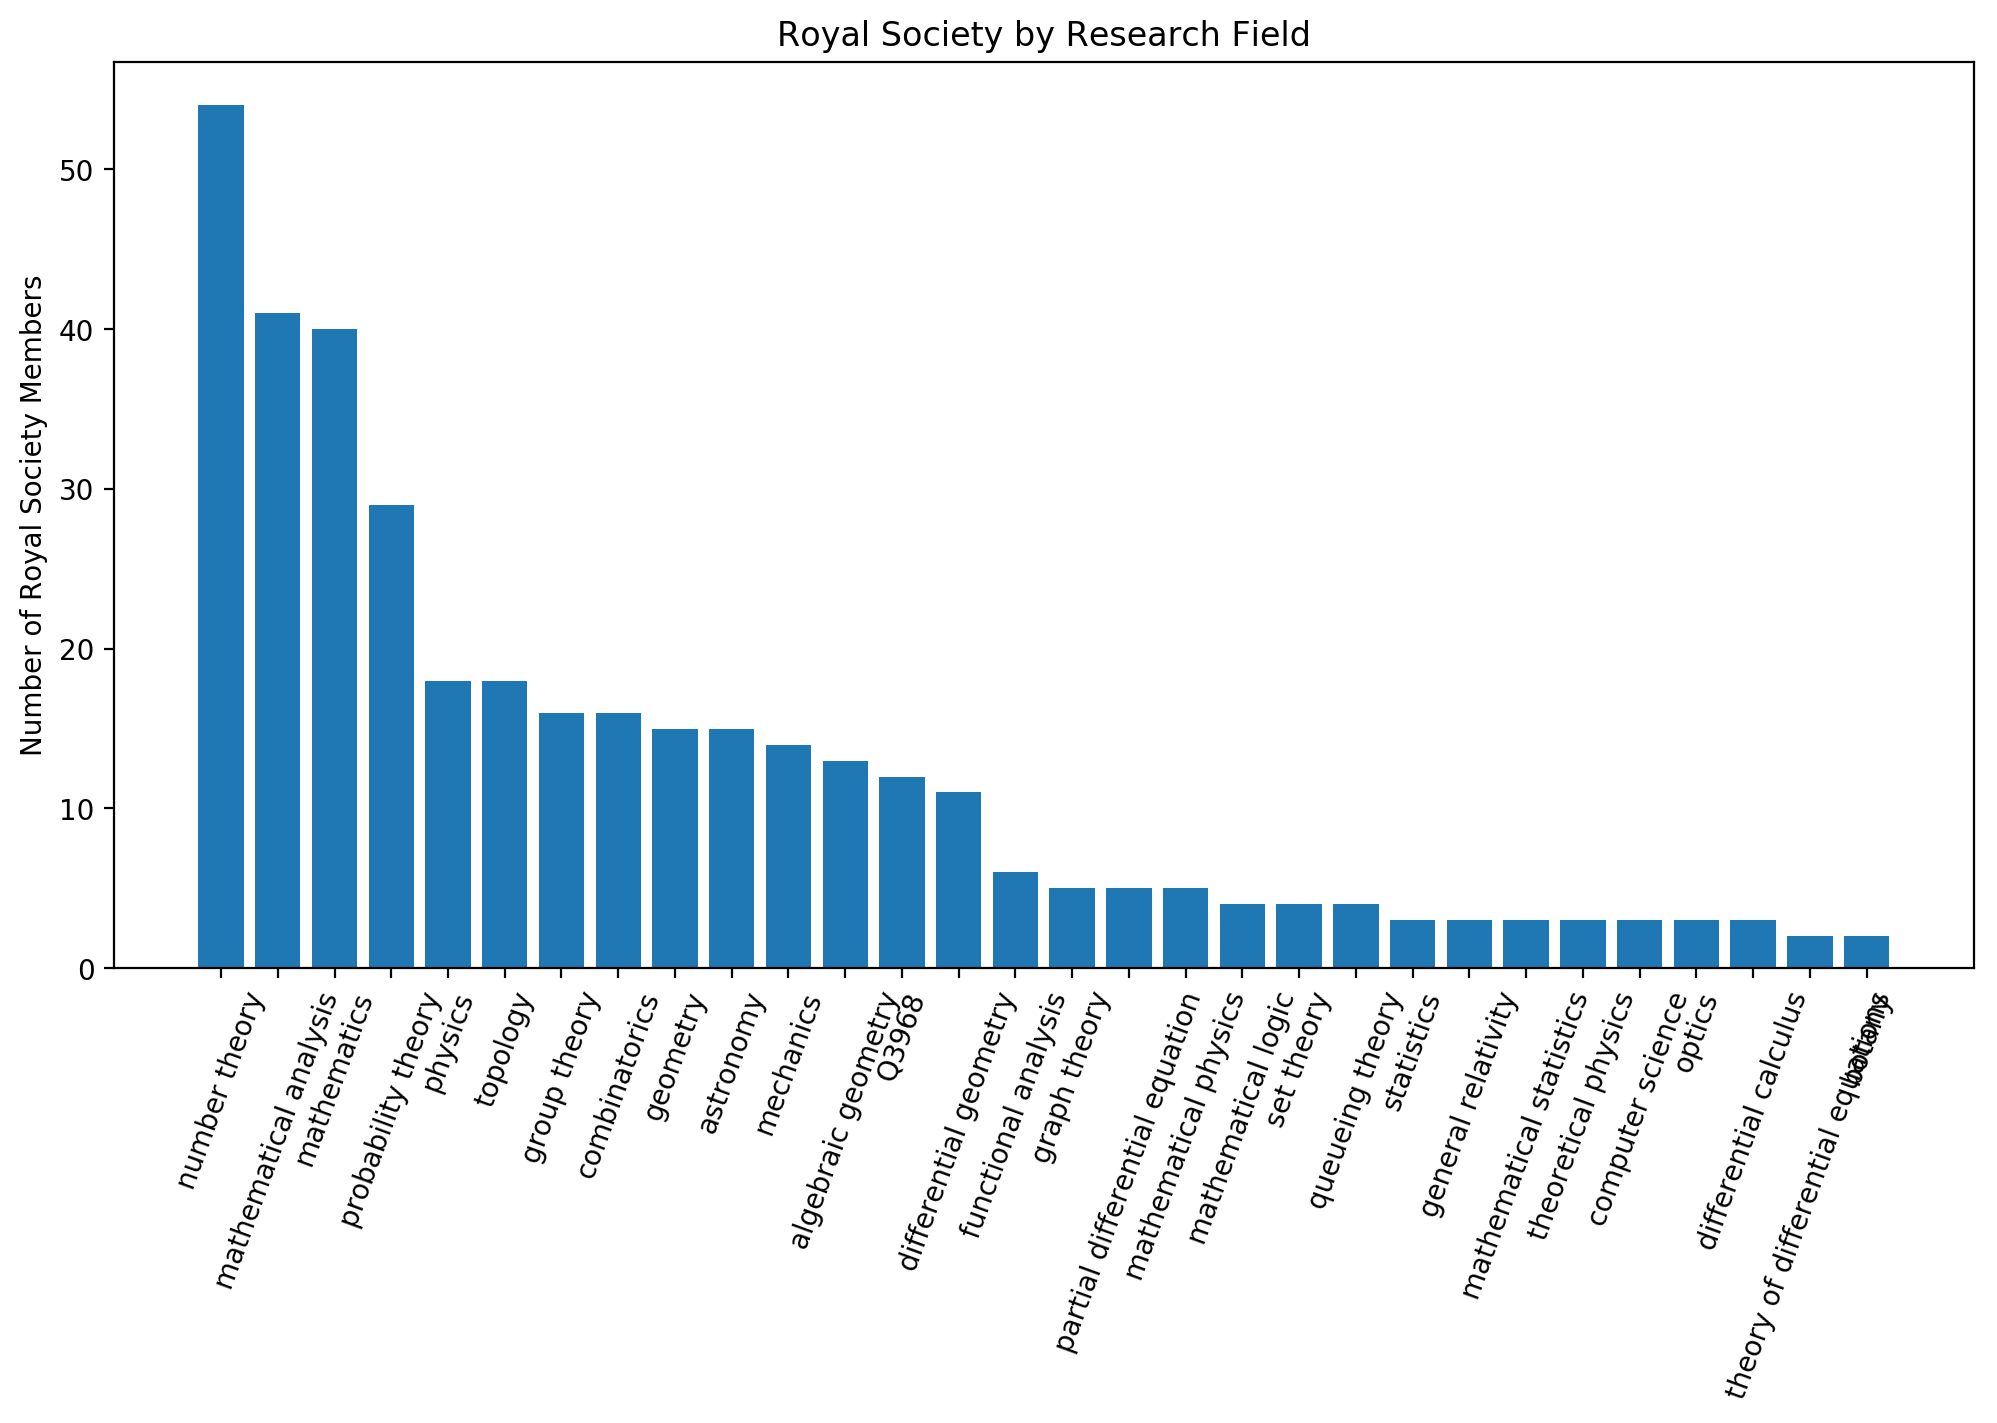

In [33]:
royal_society_grouped = royal_society_grouped.sum().sort_values(ascending=False)[:30]
plt.figure(figsize=(12, 6), dpi=200)
plt.bar(range(len(royal_society_grouped)), royal_society_grouped.values)
plt.xticks(range(len(royal_society_grouped)), royal_society_grouped.index, rotation=70)
plt.title('Royal Society by Research Field')
plt.ylabel('Number of Royal Society Members')
plt.show()

Royal Society members seem to more closely align with general Wikipedia mathematicians than with Fields Medalists, at least insofar as their areas of work and focus.

In [34]:
print('Number of Males in Royal Society', str(len(royal_society[royal_society['male']==1])))
print('Number of Females in Royal Society', str(len(royal_society[royal_society['female']==1])))
print('Proportion of Males in Royal Society', str(100 * len(royal_society[royal_society['male']==1]) / len(royal_society))[:5] + '%')

Number of Males in Royal Society 262
Number of Females in Royal Society 2
Proportion of Males in Royal Society 99.24%


Wow, the Royal Society only has 2 female members with Wikipedia pages. Despite 10% of all mathematicians with Wikipedia pages being women, the Royal society is almost entirely composed of men.

## Conclusion

In his kernel, we investigated the characteristics of Wikipedia's ~8,500 mathematicians, focusing on their demographics, age, birth, and death, profession, awards, and membership in the Royal Society. 

Among other things, we found that:
1. Wikipedia mathematicians are overwhelmingingly male
2. The proprtion of female Wikipedia mathematicians has not changed since 1850
3. Female mathematicians have only recently begun winning prestigious awards
4. Many Wikipedia mathematicians are still alive
5. Average lifespans for Wikipedia mathematicians have always been high (+60) but have risen to ~80 over the last 2,000 years.
6. Most Wikipedia mathematicians are mathematicians by profession -- those that are not tend to be computer scientists, physicists, or astronomers.
7. Fields Medalists tend to work in the same sub-discplines of math as "general" Wikipedia mathematicians, with some exceptions.
8. Royal Society members comprise a large percentage of Wikipedia mathematicians and more closely align with general Wikipedia mathematicians than with Fields Medalists.

#### Thanks for reading through. If you found this kernel informative, please upvote, comment, and share!